# Analytics - Product Quality

## Date: 2022/09

## SUMMARY:
- This notebook represents the project quality anaysis of the date exposed right below

## TEAM: MeasureSoftGram

### Semester: 2022/01

### Professor: Hilmer Neri

### Members:
- André Lucas Ferreira Lemos de Souza
- Daniel Primo de Melo
- Danillo Gonçalves de Souza
- Durval Carvalho de Souza
- Hérick Ferreira de Souza Portugues
- Heron Rodrigues Sousa
- Hugo Sobral de Lima Salomão
- Leonardo da Silva Gomes
- Lucas Ursulino Boaventura


## Libraries

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

## Graph Settings

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

## DataFrame Settings

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
repos_language = {
    'CLI': 'py',
    'Core': 'py',
    'Front': 'ts',
    'Service': 'py',
}

## SonarCloud

In [5]:
sonar_files = glob('../analytics-raw-data/*.json')

## Create DataFrame

#### Unmarshall json

In [6]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [8]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [9]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [10]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(300000)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [11]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    # df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [12]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2022-1-MeasureSoftGram-CLI',
       'fga-eps-mds-2022-1-MeasureSoftGram-Core',
       'fga-eps-mds-2022-1-MeasureSoftGram-Front',
       'fga-eps-mds-2022-1-MeasureSoftGram-Service'], dtype=object)

### Create dataframe per repository

In [13]:
core_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-MeasureSoftGram-'+'Core']
service_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-MeasureSoftGram-'+'Service']
front_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-MeasureSoftGram-'+'Front']
cli_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-MeasureSoftGram-'+'CLI']

## Measure calculations according to Q-Rapids quality model

In [14]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [15]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [16]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [17]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [18]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [19]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [20]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [21]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m3_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [22]:
core_metrics = create_metrics_df(core_df)
service_metrics = create_metrics_df(service_df)
front_metrics = create_metrics_df(front_df)
cli_metrics = create_metrics_df(cli_df)

## Data visualization

### CLI visualization

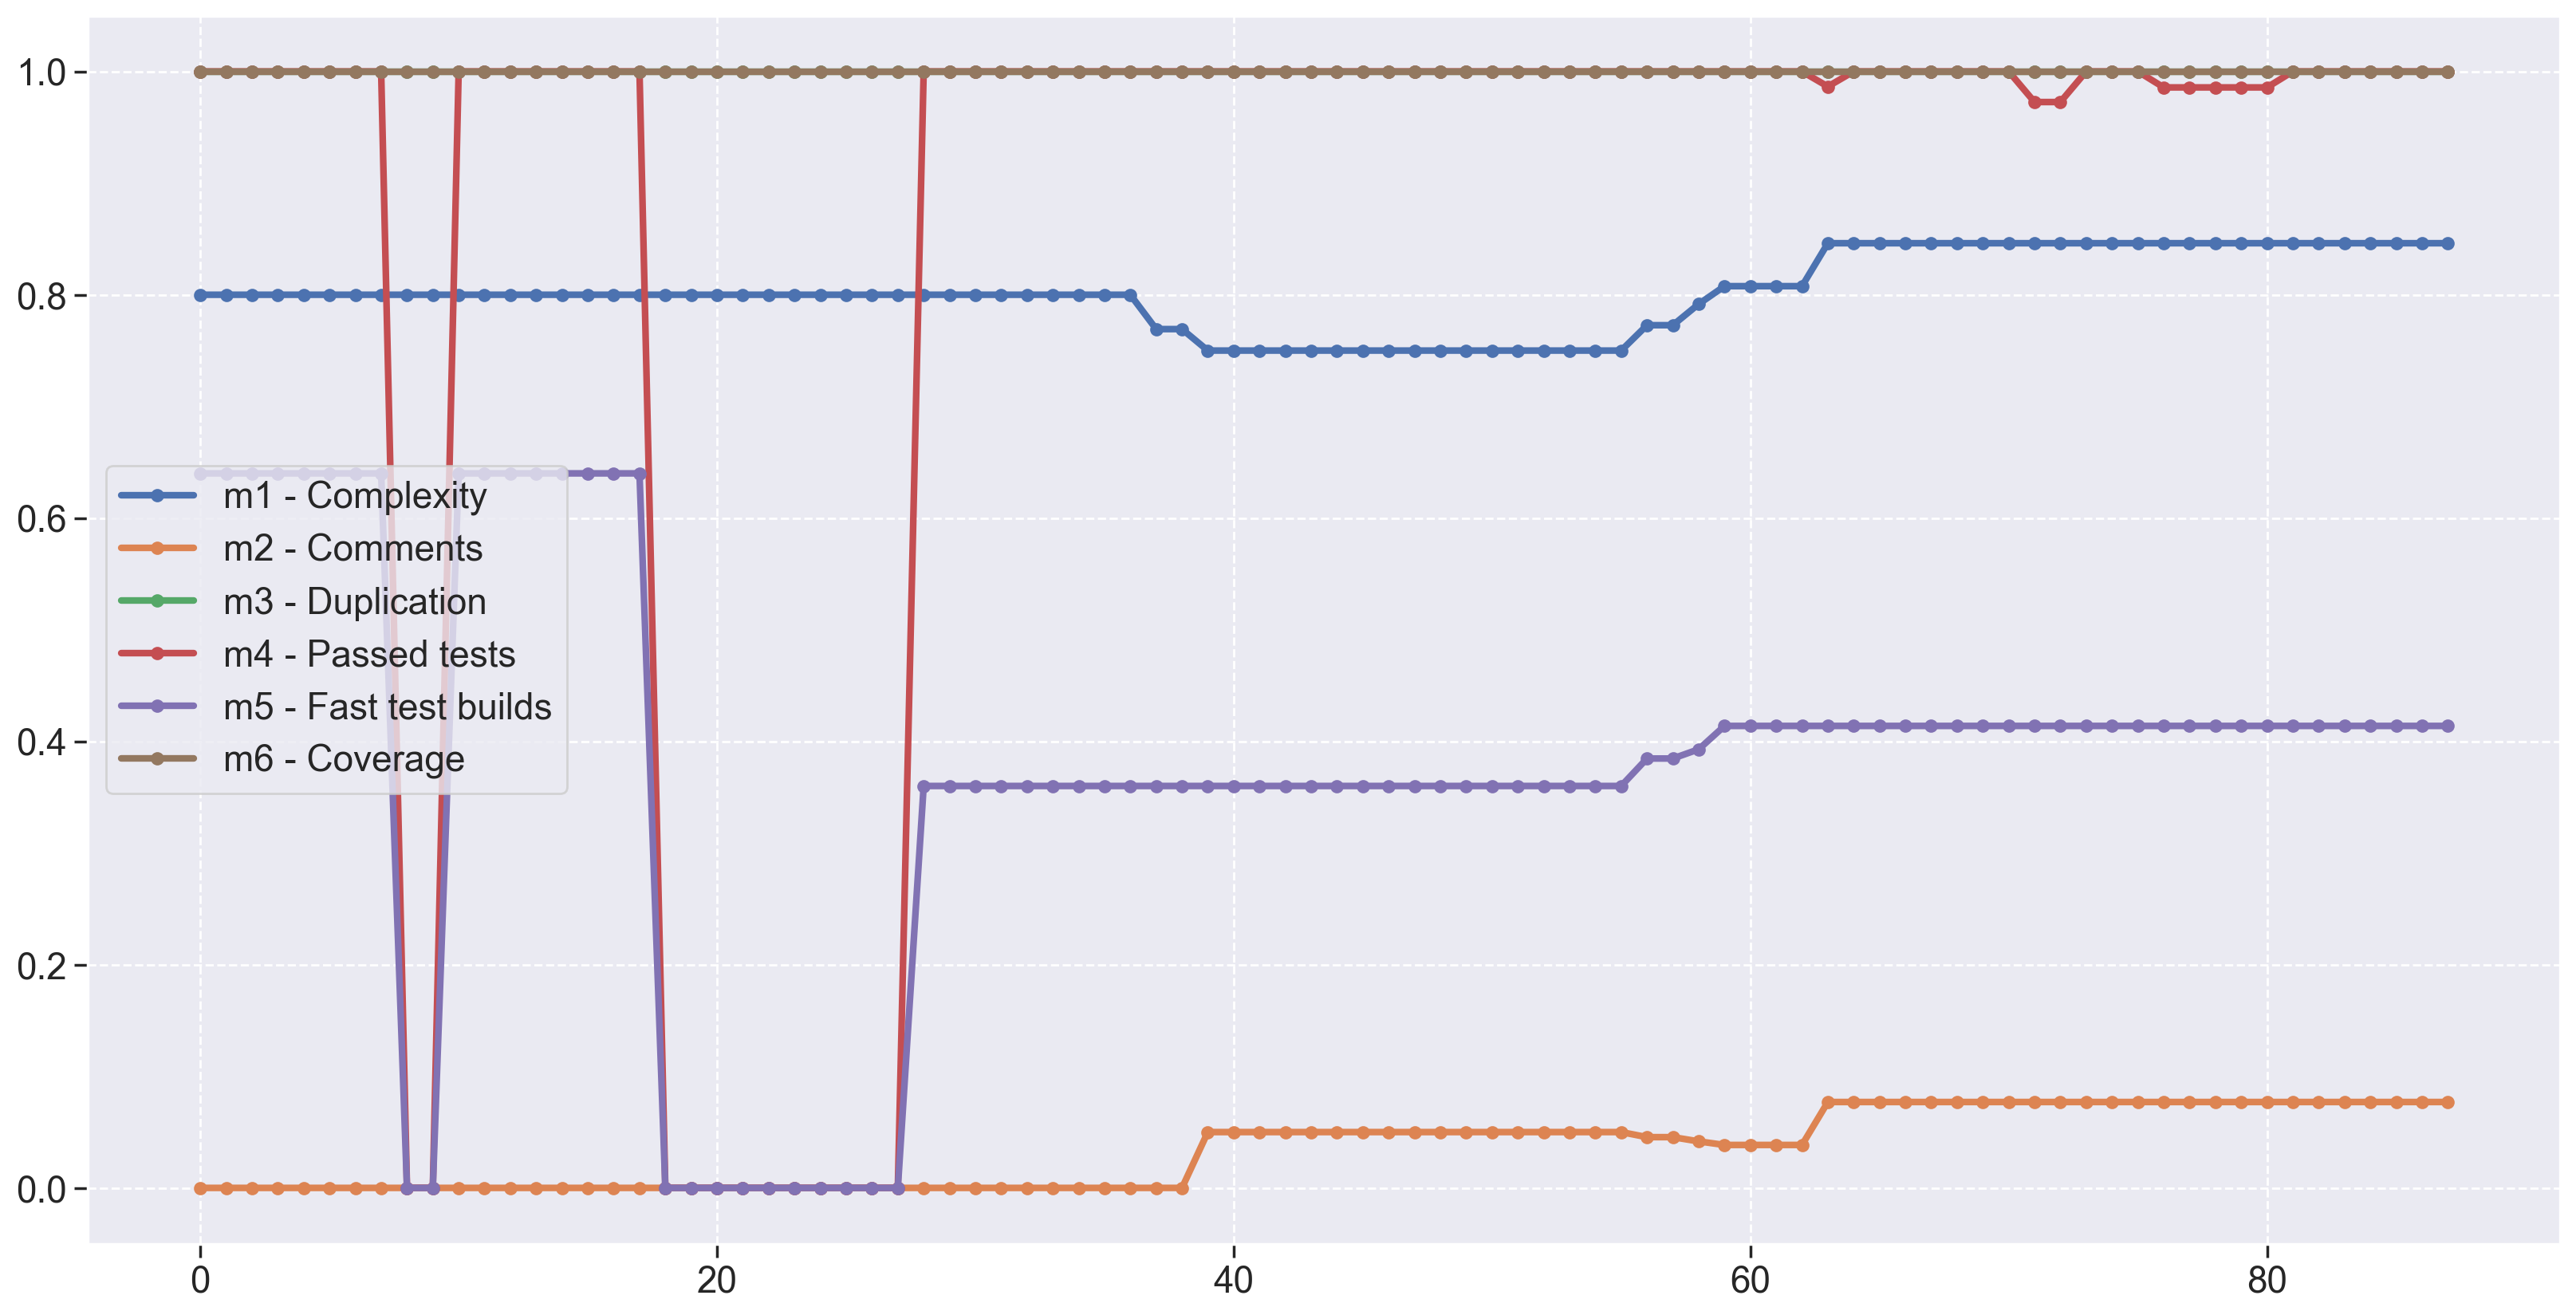

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['m1'], linewidth=3, marker='o', markersize=5, label="m1 - Complexity")
plt.plot(cli_metrics['m2'], linewidth=3, marker='o', markersize=5, label="m2 - Comments")
plt.plot(cli_metrics['m3'], linewidth=3, marker='o', markersize=5, label="m3 - Duplication")
plt.plot(cli_metrics['m4'], linewidth=3, marker='o', markersize=5, label="m4 - Passed tests")
plt.plot(cli_metrics['m5'], linewidth=3, marker='o', markersize=5, label="m5 - Fast test builds")
plt.plot(cli_metrics['m6'], linewidth=3, marker='o', markersize=5, label="m6 - Coverage")

plt.legend(loc='best')

### Core visualization

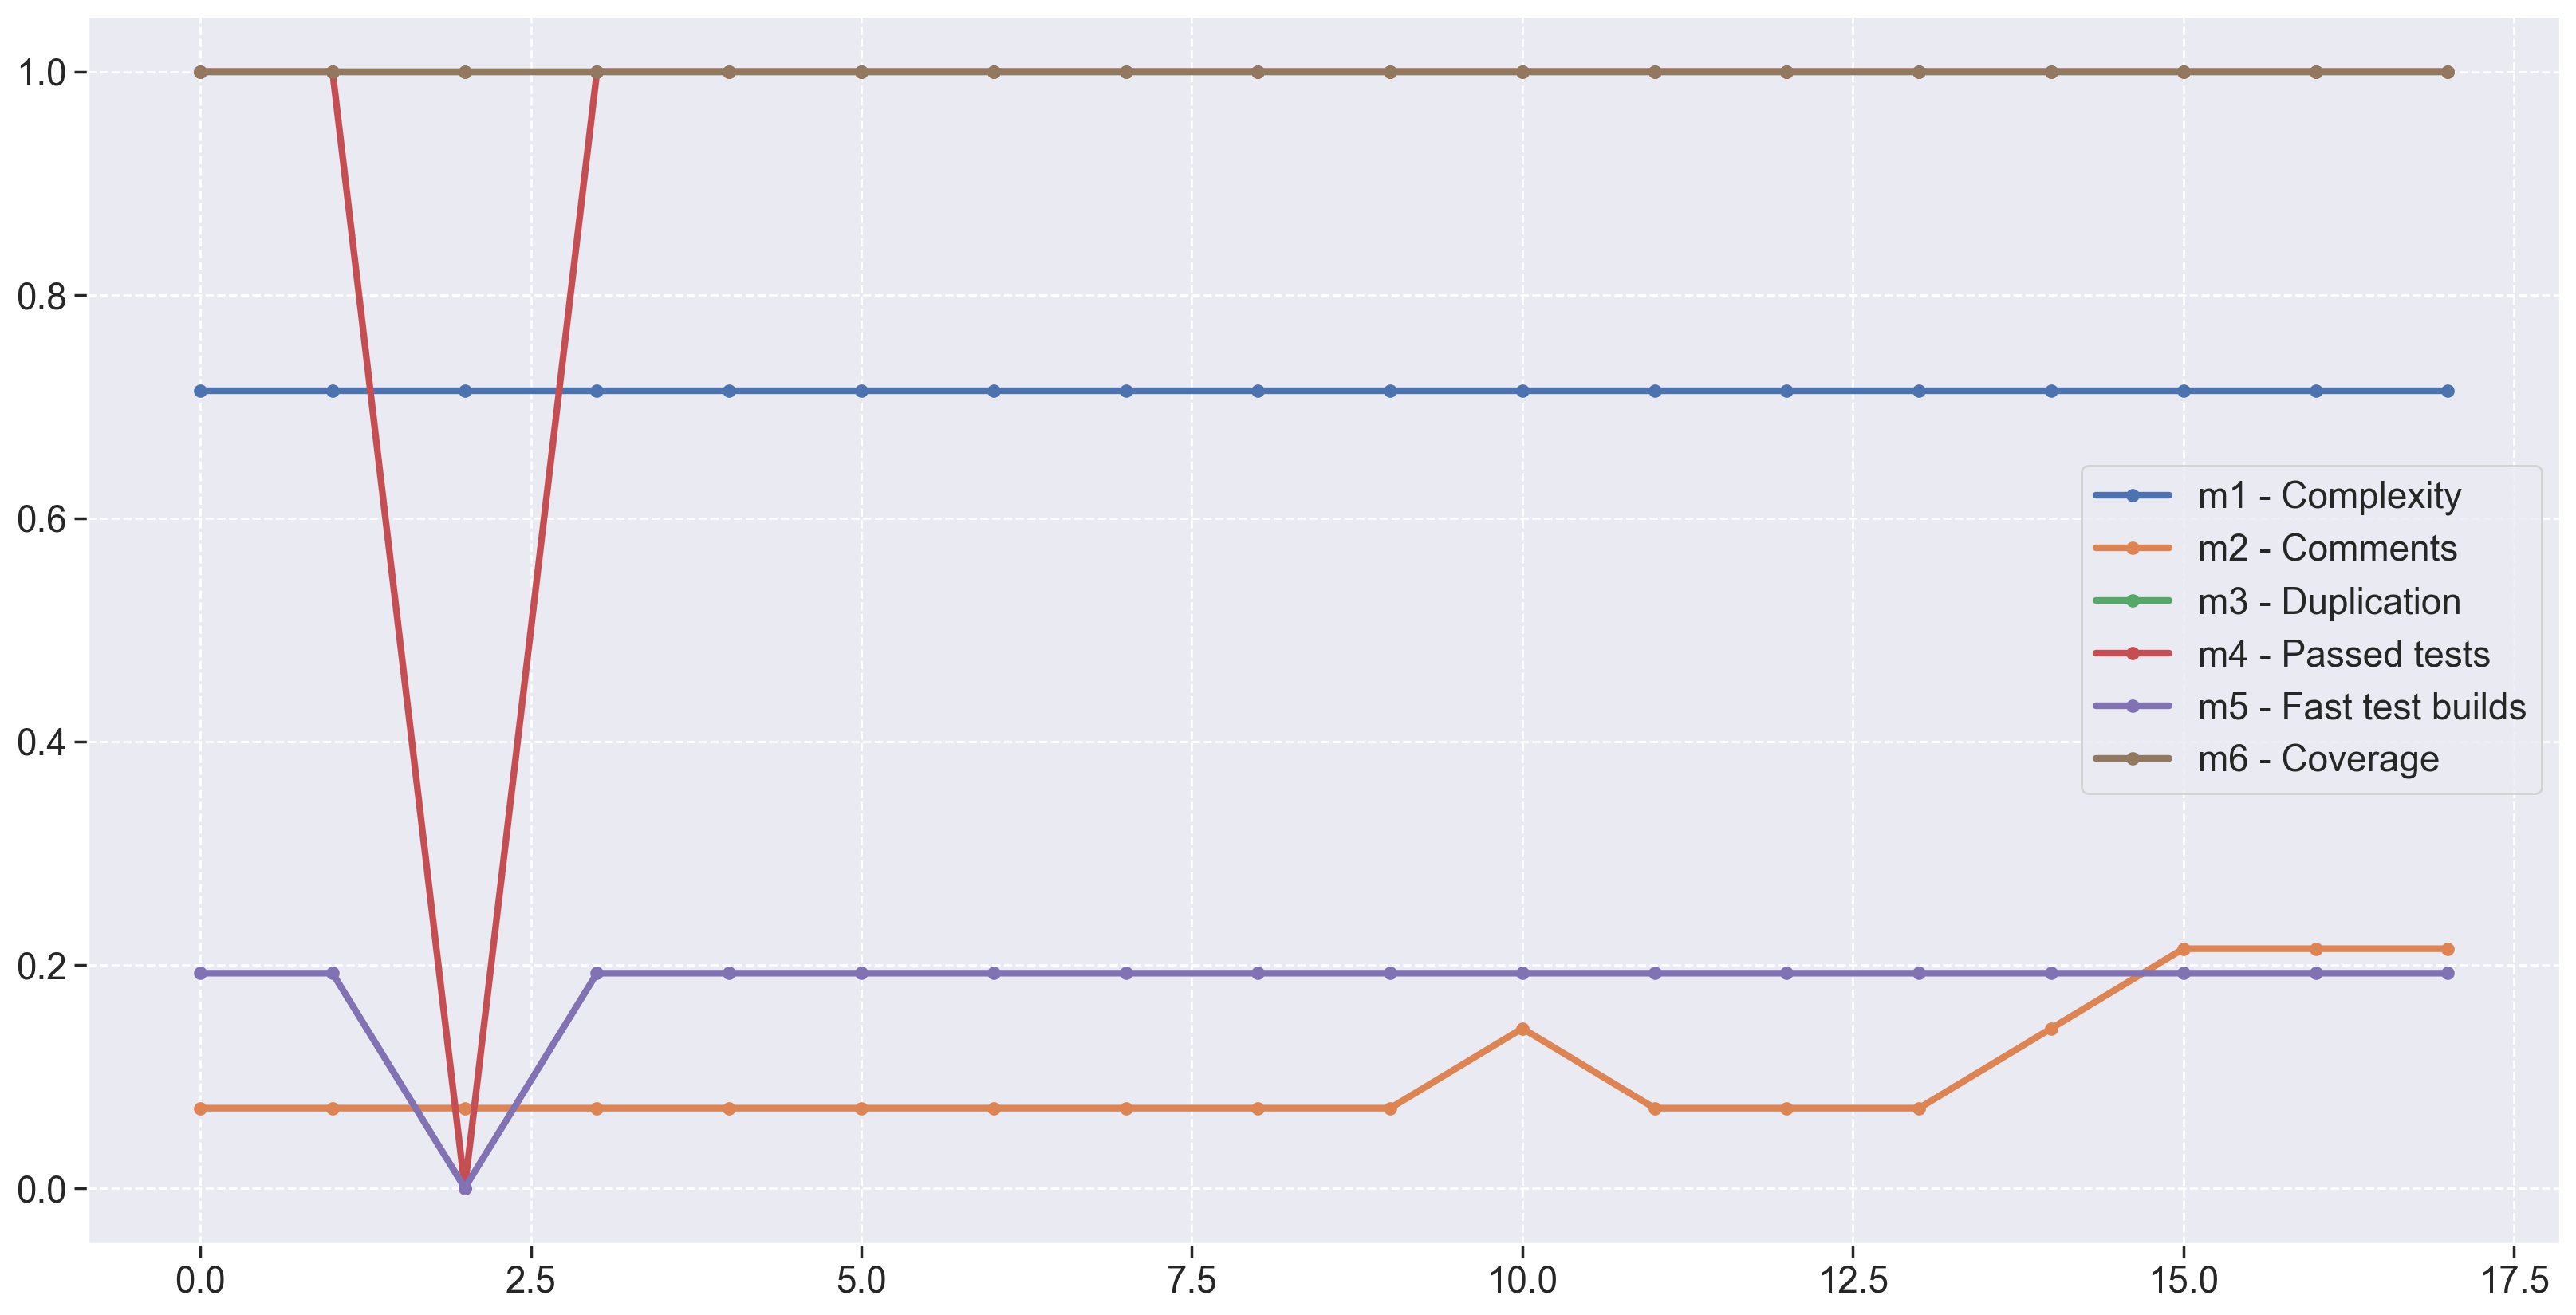

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(core_metrics['m1'], linewidth=3, marker='o', markersize=5, label="m1 - Complexity")
plt.plot(core_metrics['m2'], linewidth=3, marker='o', markersize=5, label="m2 - Comments")
plt.plot(core_metrics['m3'], linewidth=3, marker='o', markersize=5, label="m3 - Duplication")
plt.plot(core_metrics['m4'], linewidth=3, marker='o', markersize=5, label="m4 - Passed tests")
plt.plot(core_metrics['m5'], linewidth=3, marker='o', markersize=5, label="m5 - Fast test builds")
plt.plot(core_metrics['m6'], linewidth=3, marker='o', markersize=5, label="m6 - Coverage")

plt.legend(loc='best')

### Dashboard visualization

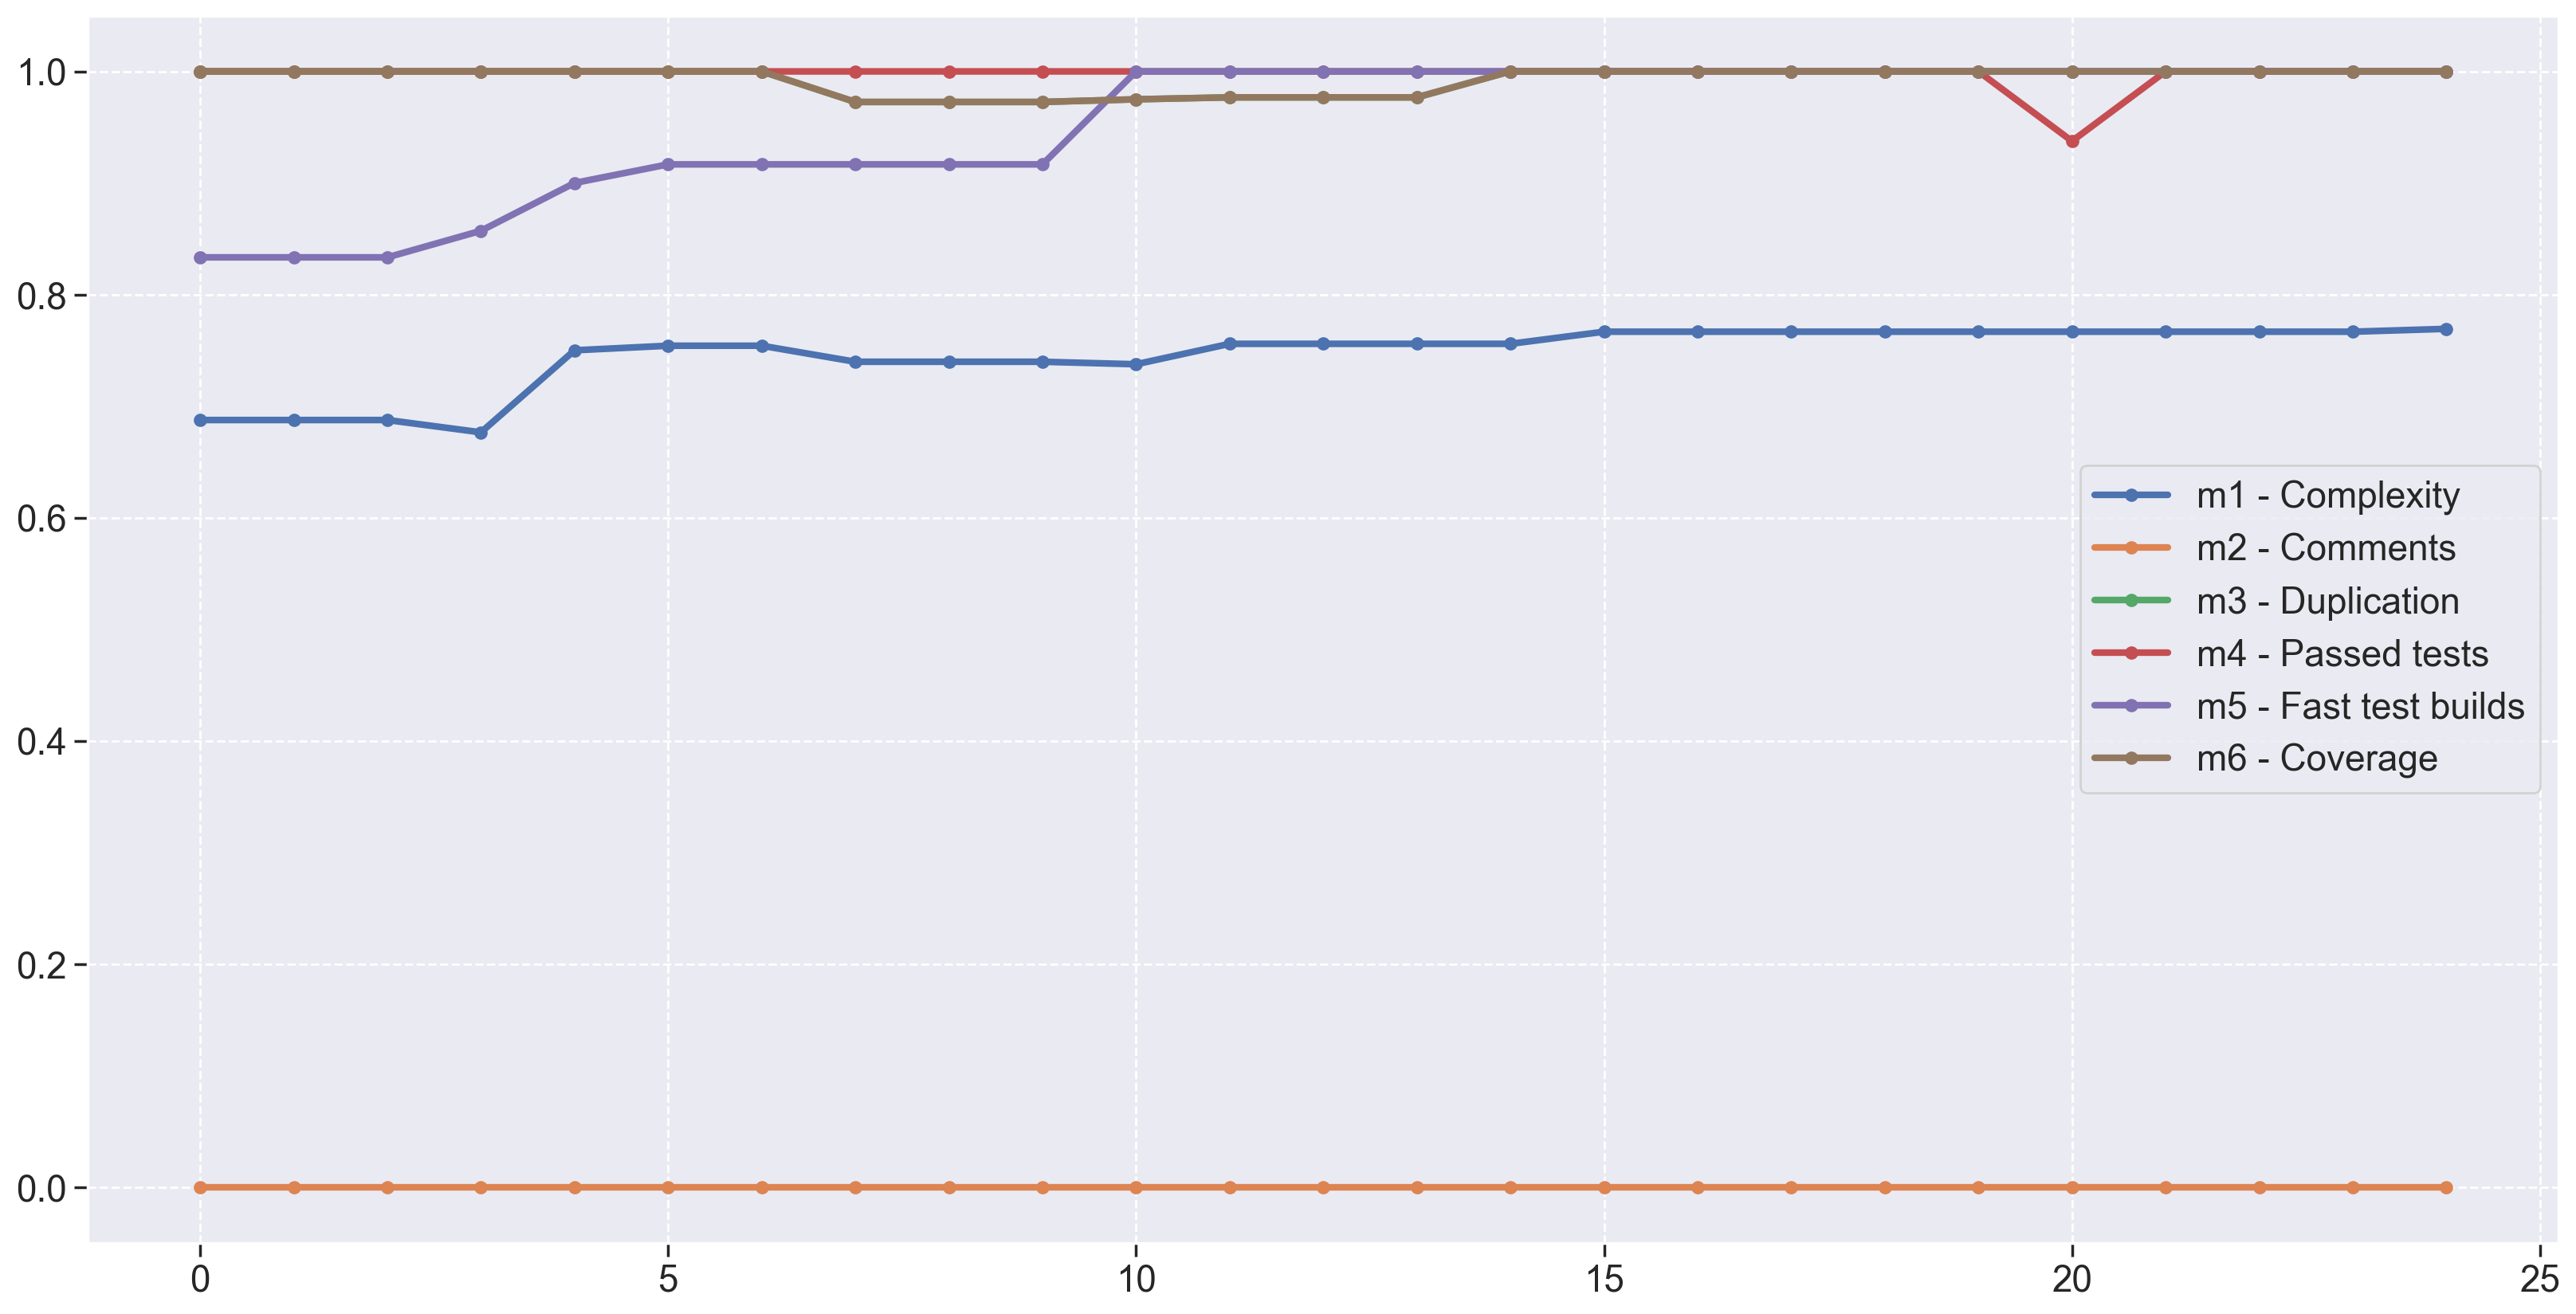

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(front_metrics['m1'], linewidth=3, marker='o', markersize=5, label="m1 - Complexity")
plt.plot(front_metrics['m2'], linewidth=3, marker='o', markersize=5, label="m2 - Comments")
plt.plot(front_metrics['m3'], linewidth=3, marker='o', markersize=5, label="m3 - Duplication")
plt.plot(front_metrics['m4'], linewidth=3, marker='o', markersize=5, label="m4 - Passed tests")
plt.plot(front_metrics['m5'], linewidth=3, marker='o', markersize=5, label="m5 - Fast test builds")
plt.plot(front_metrics['m6'], linewidth=3, marker='o', markersize=5, label="m6 - Coverage")

plt.legend(loc='best')

### Service visualization

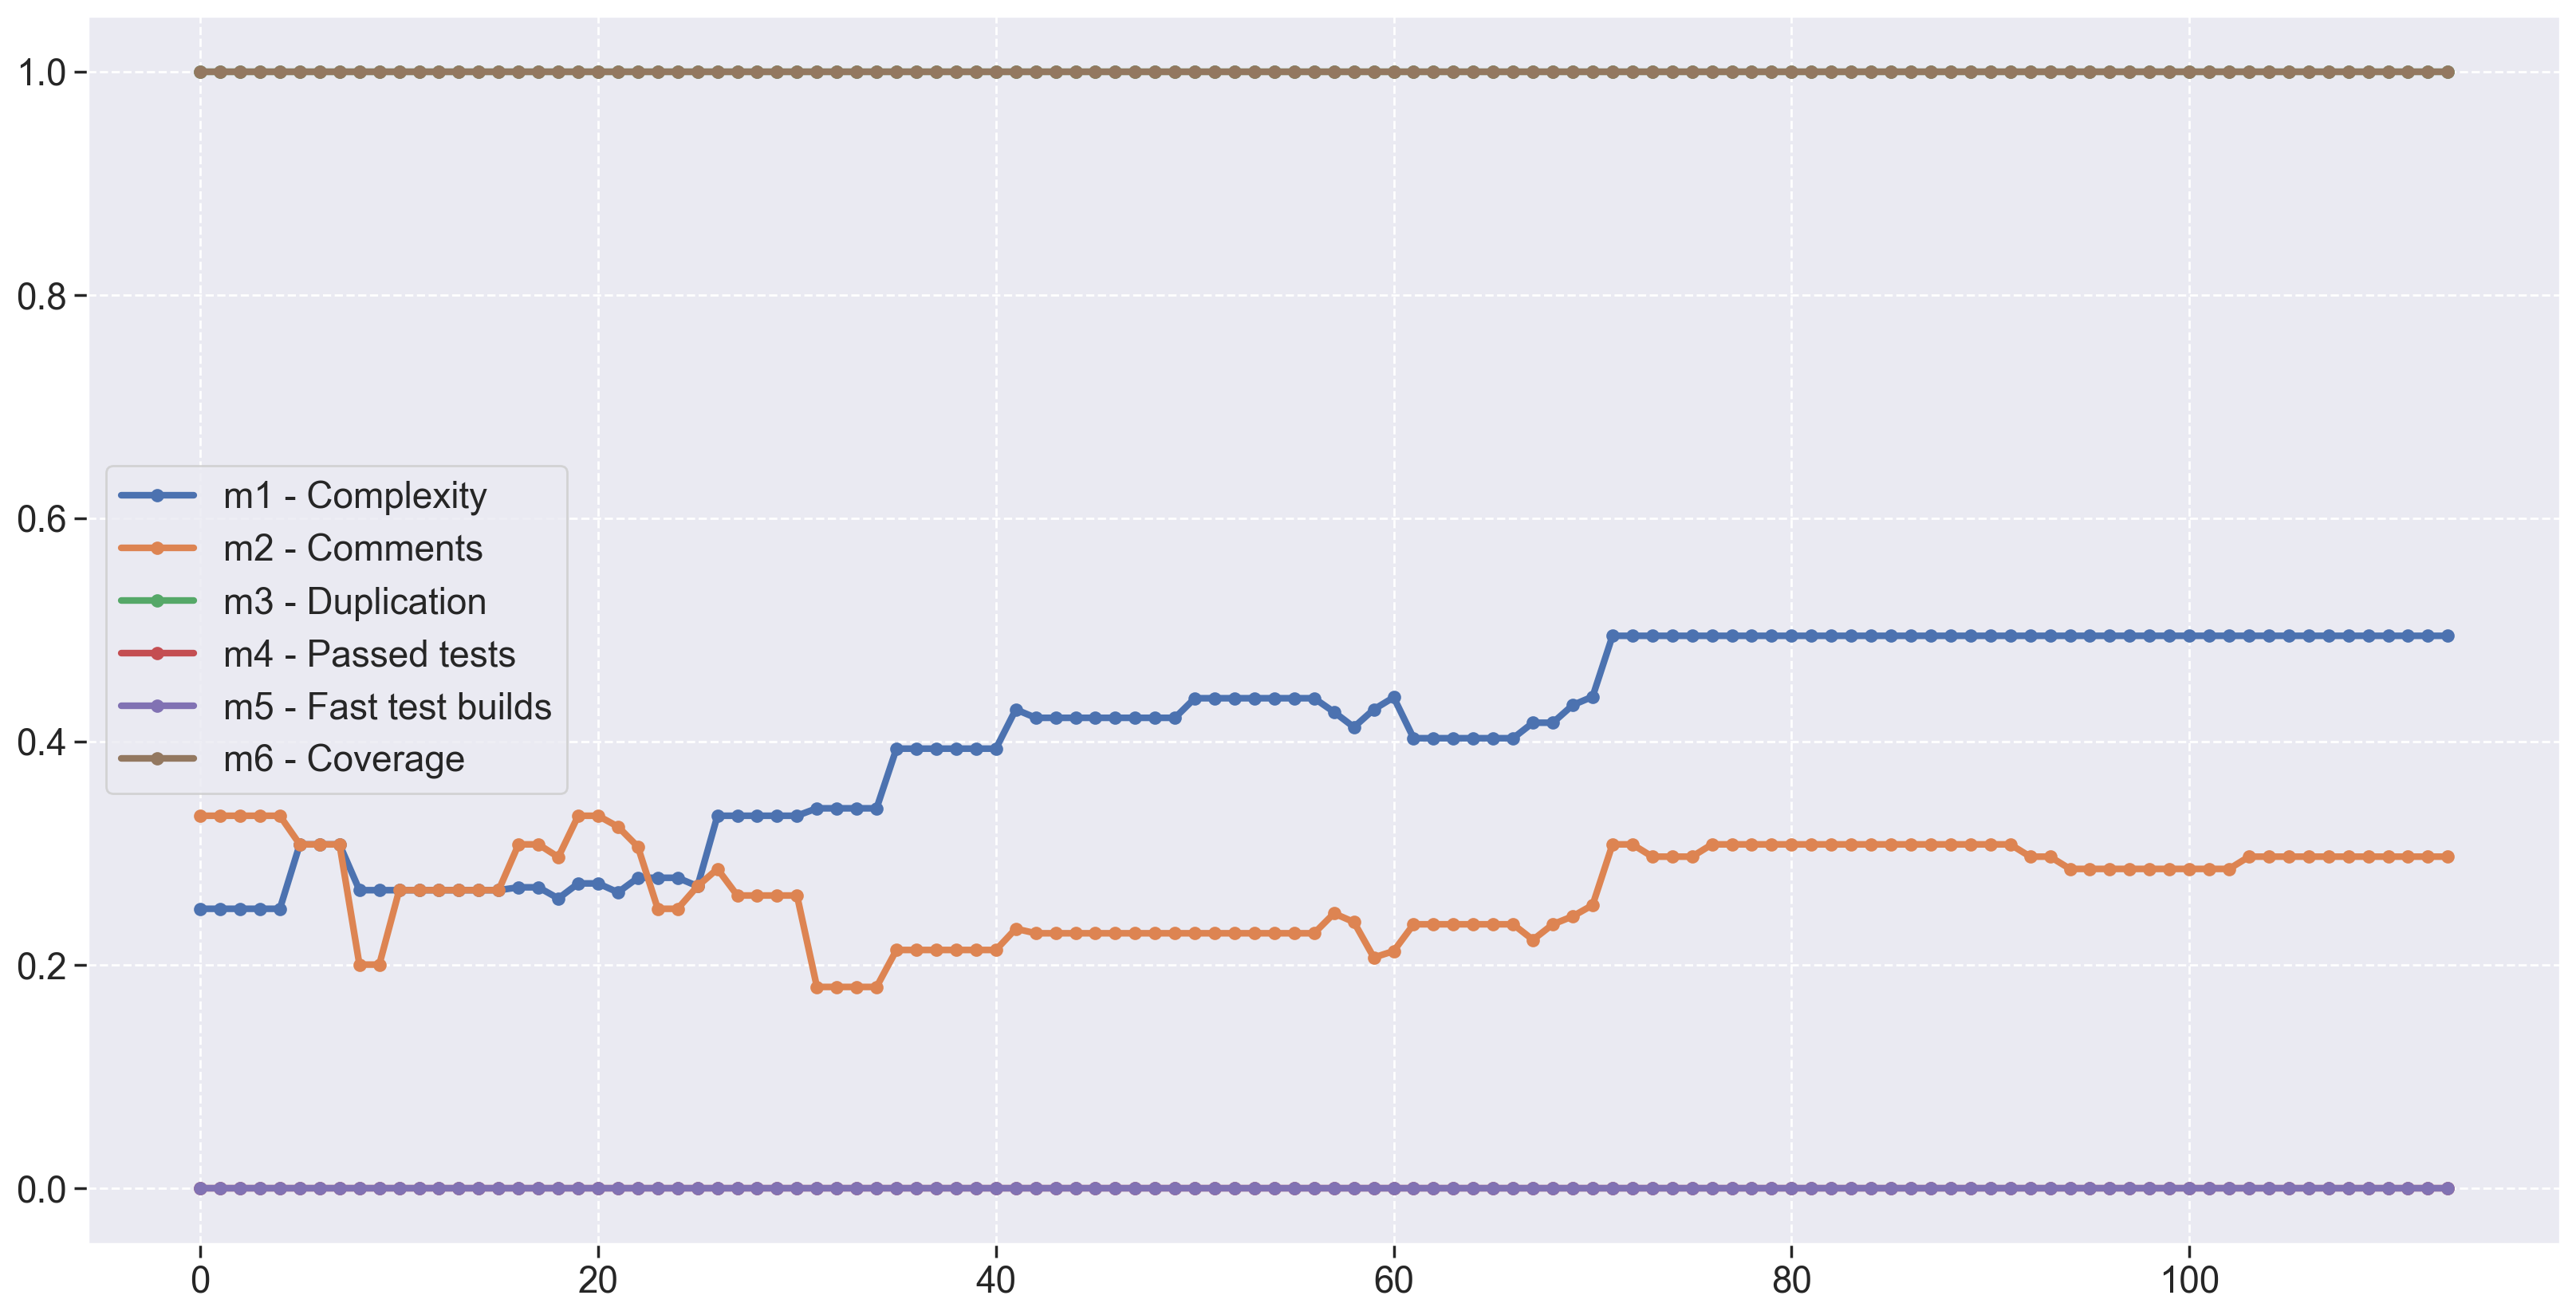

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.plot(service_metrics['m1'], linewidth=3, marker='o', markersize=5, label="m1 - Complexity")
plt.plot(service_metrics['m2'], linewidth=3, marker='o', markersize=5, label="m2 - Comments")
plt.plot(service_metrics['m3'], linewidth=3, marker='o', markersize=5, label="m3 - Duplication")
plt.plot(service_metrics['m4'], linewidth=3, marker='o', markersize=5, label="m4 - Passed tests")
plt.plot(service_metrics['m5'], linewidth=3, marker='o', markersize=5, label="m5 - Fast test builds")
plt.plot(service_metrics['m6'], linewidth=3, marker='o', markersize=5, label="m6 - Coverage")

plt.legend(loc='best')

## Quality factor and aspect aggregation

In [27]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5

cli_metrics['code_quality'] = ((cli_metrics['m1']*pm1) + (cli_metrics['m2']*pm2) + (cli_metrics['m3']*pm3)) * psc1
core_metrics['code_quality'] = ((core_metrics['m1']*pm1) + (core_metrics['m2']*pm2) + (core_metrics['m3']*pm3)) * psc1
front_metrics['code_quality'] = ((front_metrics['m1']*pm1) + (front_metrics['m2']*pm2) + (front_metrics['m3']*pm3)) * psc1
service_metrics['code_quality'] = ((service_metrics['m1']*pm1) + (service_metrics['m2']*pm2) + (service_metrics['m3']*pm3)) * psc1


cli_metrics['testing_status'] = ((cli_metrics['m4']*pm4) + (cli_metrics['m5']*pm5) + (cli_metrics['m6']*pm6)) * psc2
core_metrics['testing_status'] = ((core_metrics['m4']*pm4) + (core_metrics['m5']*pm5) + (core_metrics['m6']*pm6)) * psc2
front_metrics['testing_status'] = ((front_metrics['m4']*pm4) + (front_metrics['m5']*pm5) + (front_metrics['m6']*pm6)) * psc2
service_metrics['testing_status'] = ((service_metrics['m4']*pm4) + (service_metrics['m5']*pm5) + (service_metrics['m6']*pm6)) * psc2


### Code Quality visualization

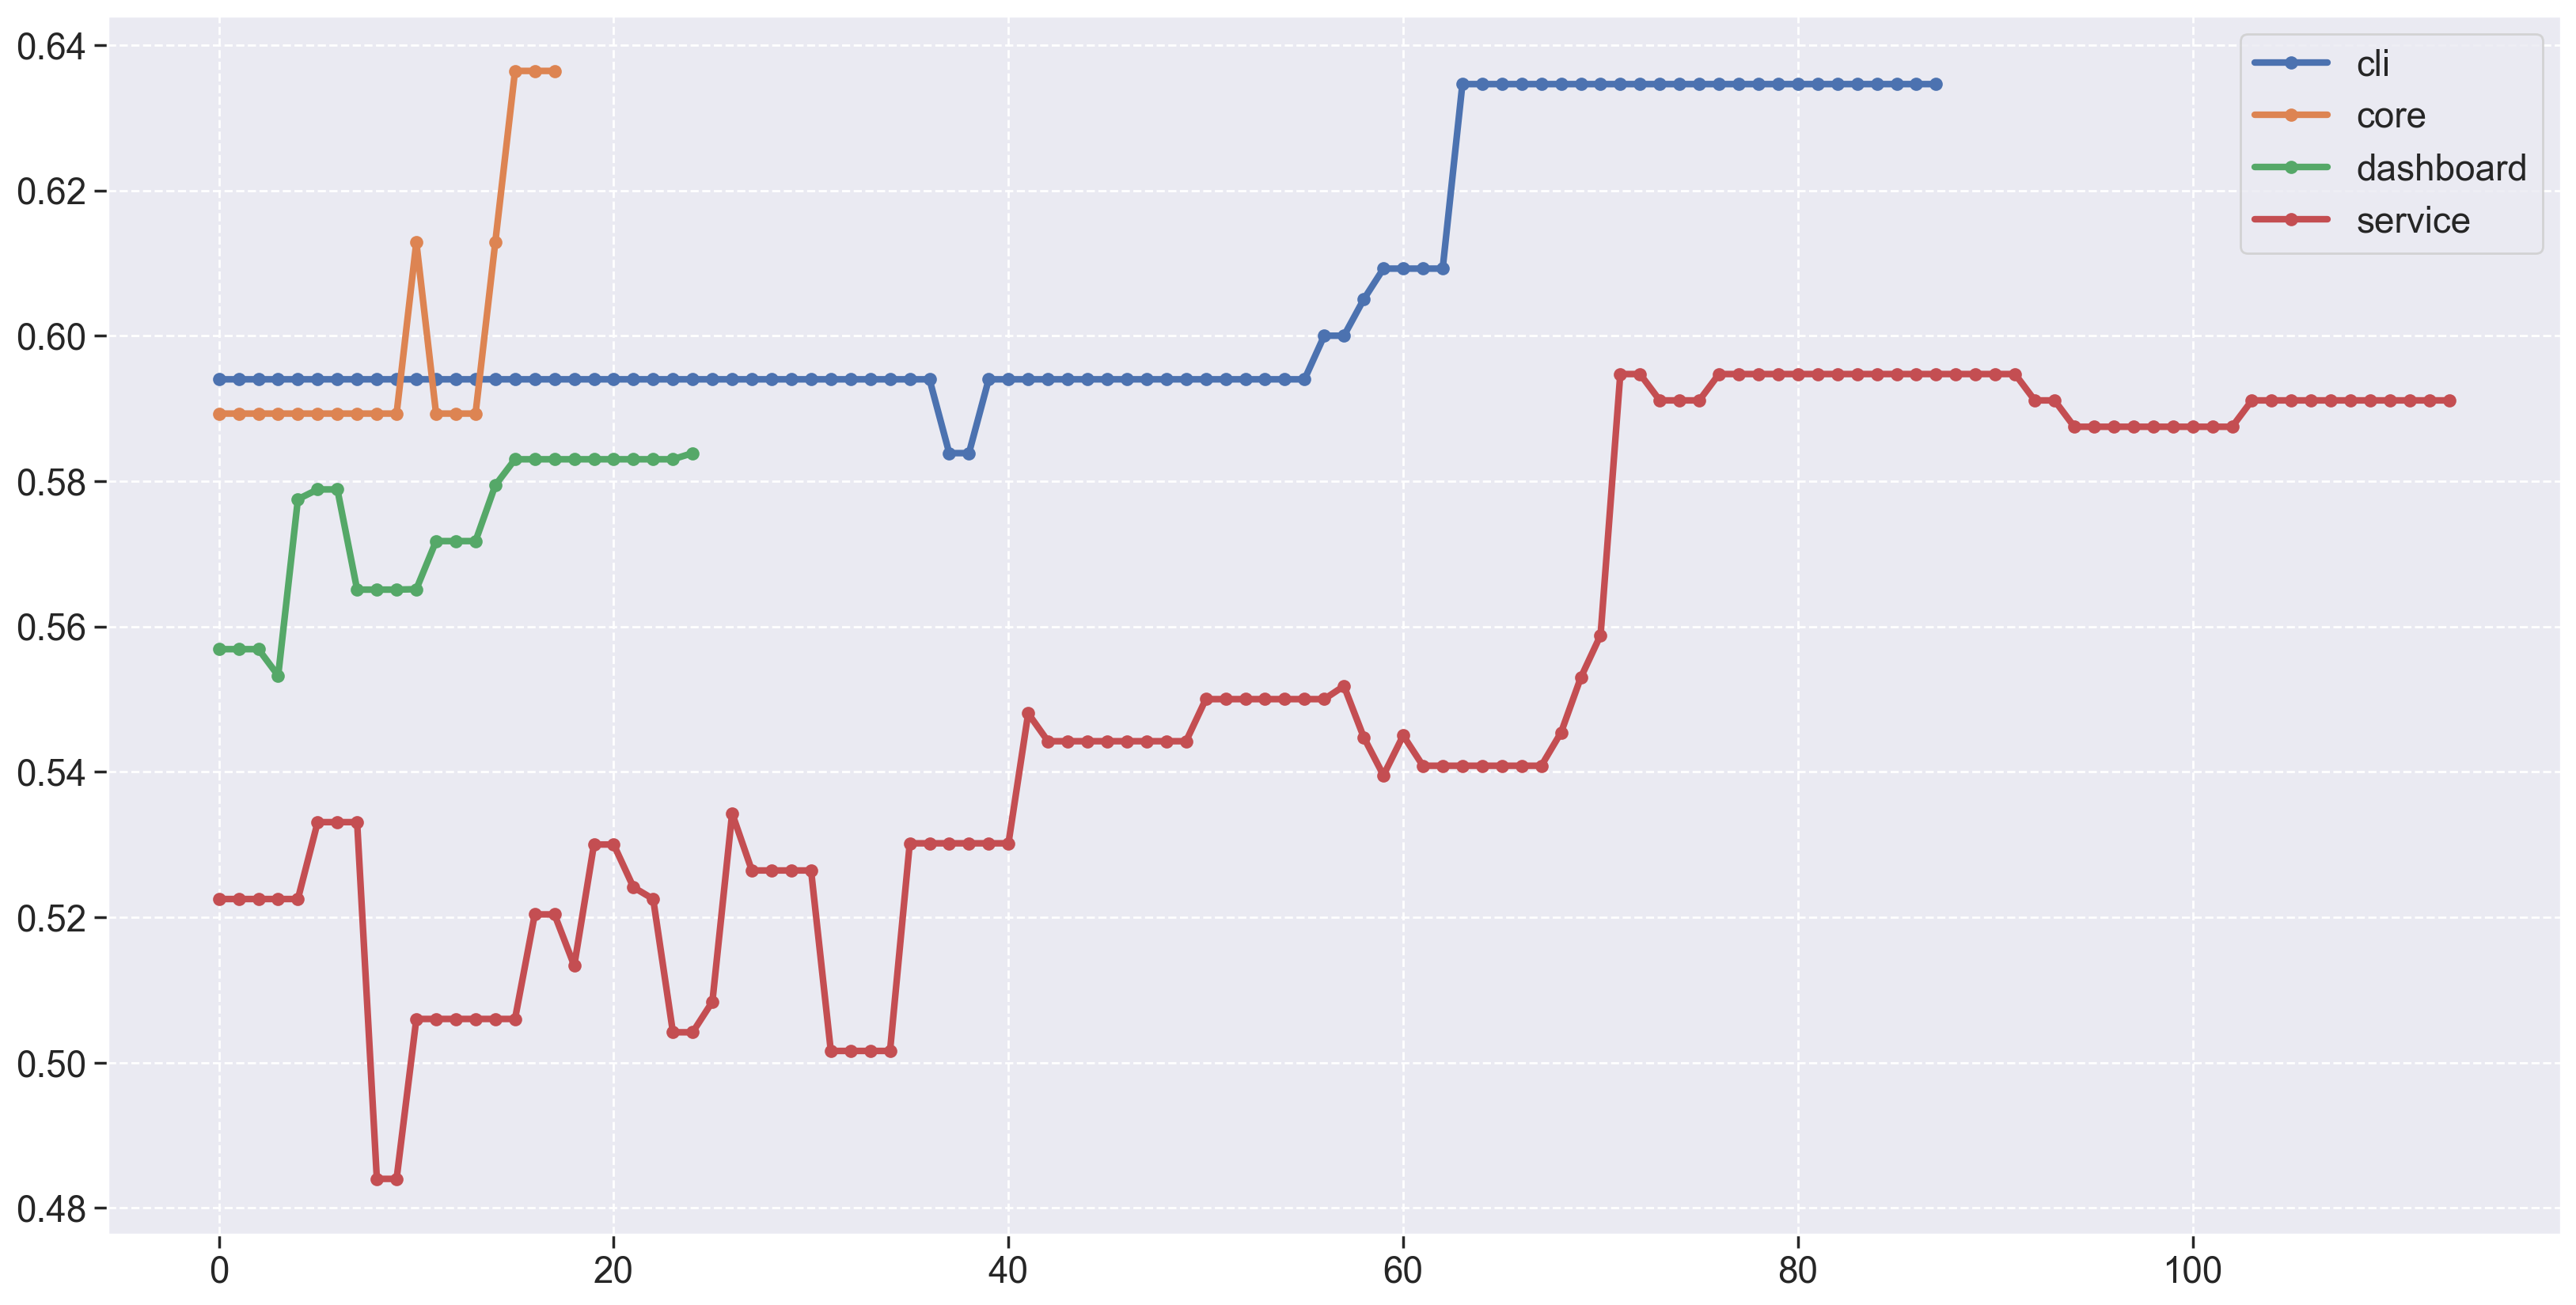

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="cli")
plt.plot(core_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="core")
plt.plot(front_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="dashboard")
plt.plot(service_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label="service")

plt.legend(loc='best')

### Testing Status visualization

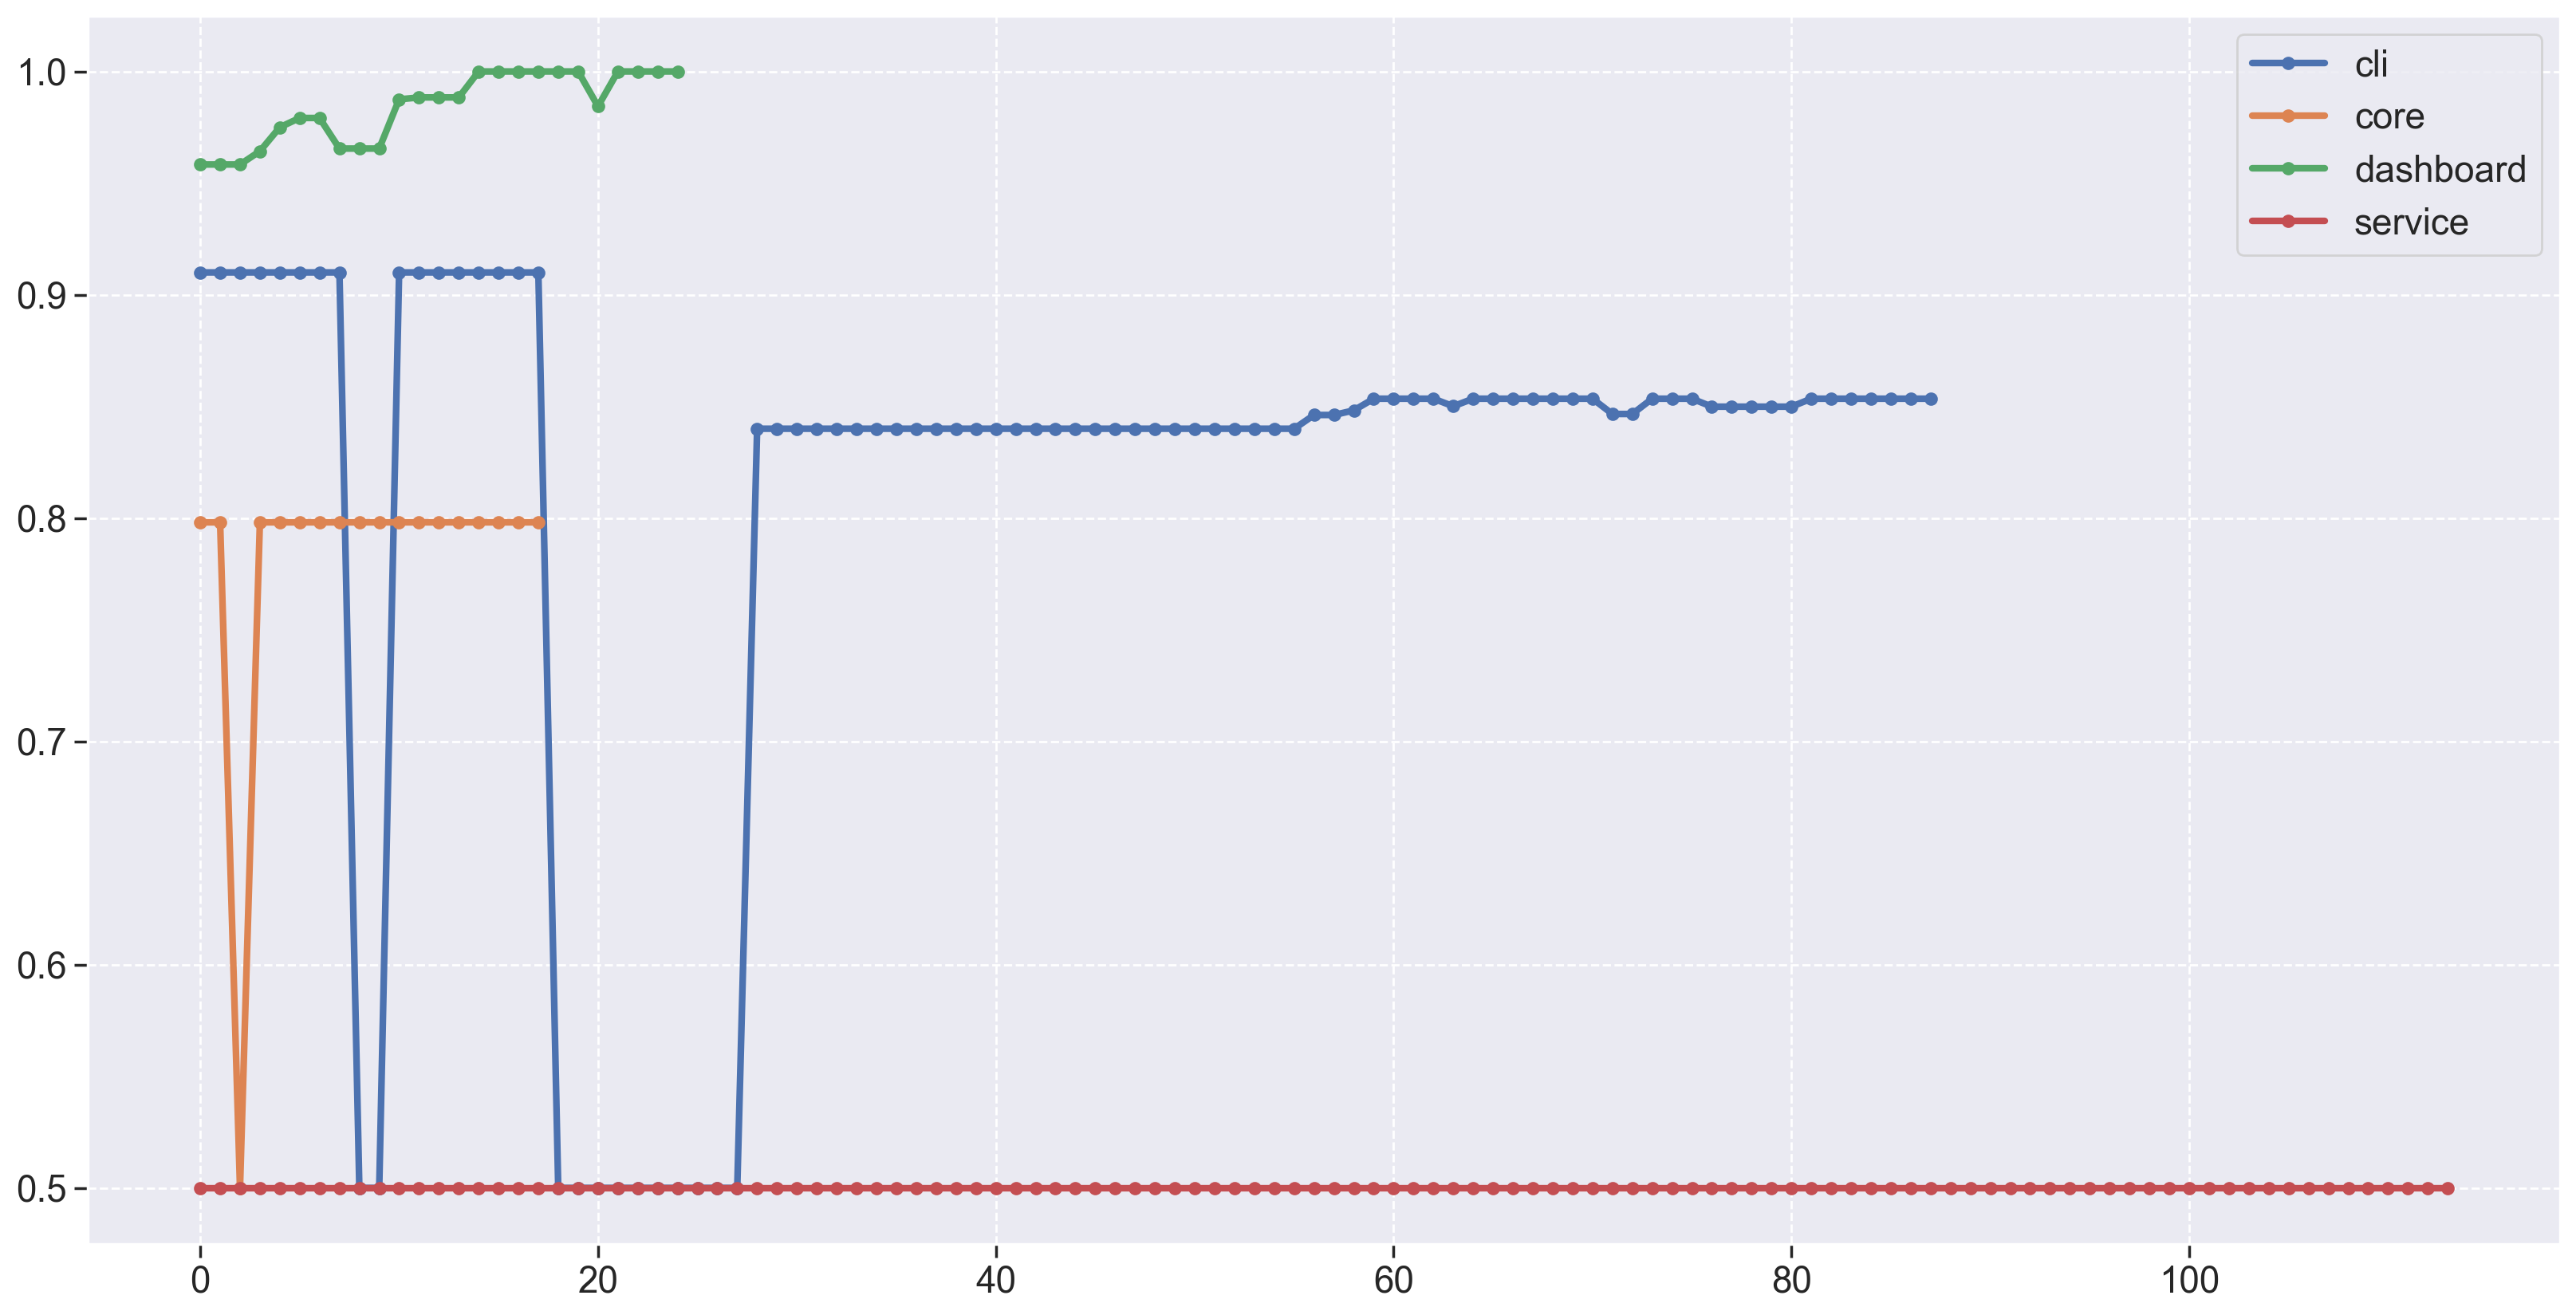

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="cli")
plt.plot(core_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="core")
plt.plot(front_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="dashboard")
plt.plot(service_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label="service")

plt.legend(loc='best')

### Aggregations

In [30]:
cli_metrics['Maintainability'] = cli_metrics['code_quality'] * pc1
cli_metrics['Reliability'] = cli_metrics['testing_status'] * pc2
cli_metrics['total'] = cli_metrics['Maintainability'] + cli_metrics['Reliability']

core_metrics['Maintainability'] = core_metrics['code_quality'] * pc1
core_metrics['Reliability'] = core_metrics['testing_status'] * pc2
core_metrics['total'] = core_metrics['Maintainability'] + core_metrics['Reliability']

front_metrics['Maintainability'] = front_metrics['code_quality'] * pc1
front_metrics['Reliability'] = front_metrics['testing_status'] * pc2
front_metrics['total'] = front_metrics['Maintainability'] + front_metrics['Reliability']

service_metrics['Maintainability'] = service_metrics['code_quality'] * pc1
service_metrics['Reliability'] = service_metrics['testing_status'] * pc2
service_metrics['total'] = service_metrics['Maintainability'] + service_metrics['Reliability']

## Repositories analysis

In [31]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

## CLI Analysis

In [32]:
maintainability_stats = pd.DataFrame(get_characteristc_stats(cli_metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(cli_metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [33]:
print(maintainability_stats)

       mean   mode  median       std       var       min       max
0  0.303131  0.297   0.297  0.009182  0.000084  0.291923  0.317308


In [34]:
print(reliability_stats)

       mean  mode    median       std       var   min    max
0  0.405316  0.42  0.423703  0.063298  0.004007  0.25  0.455


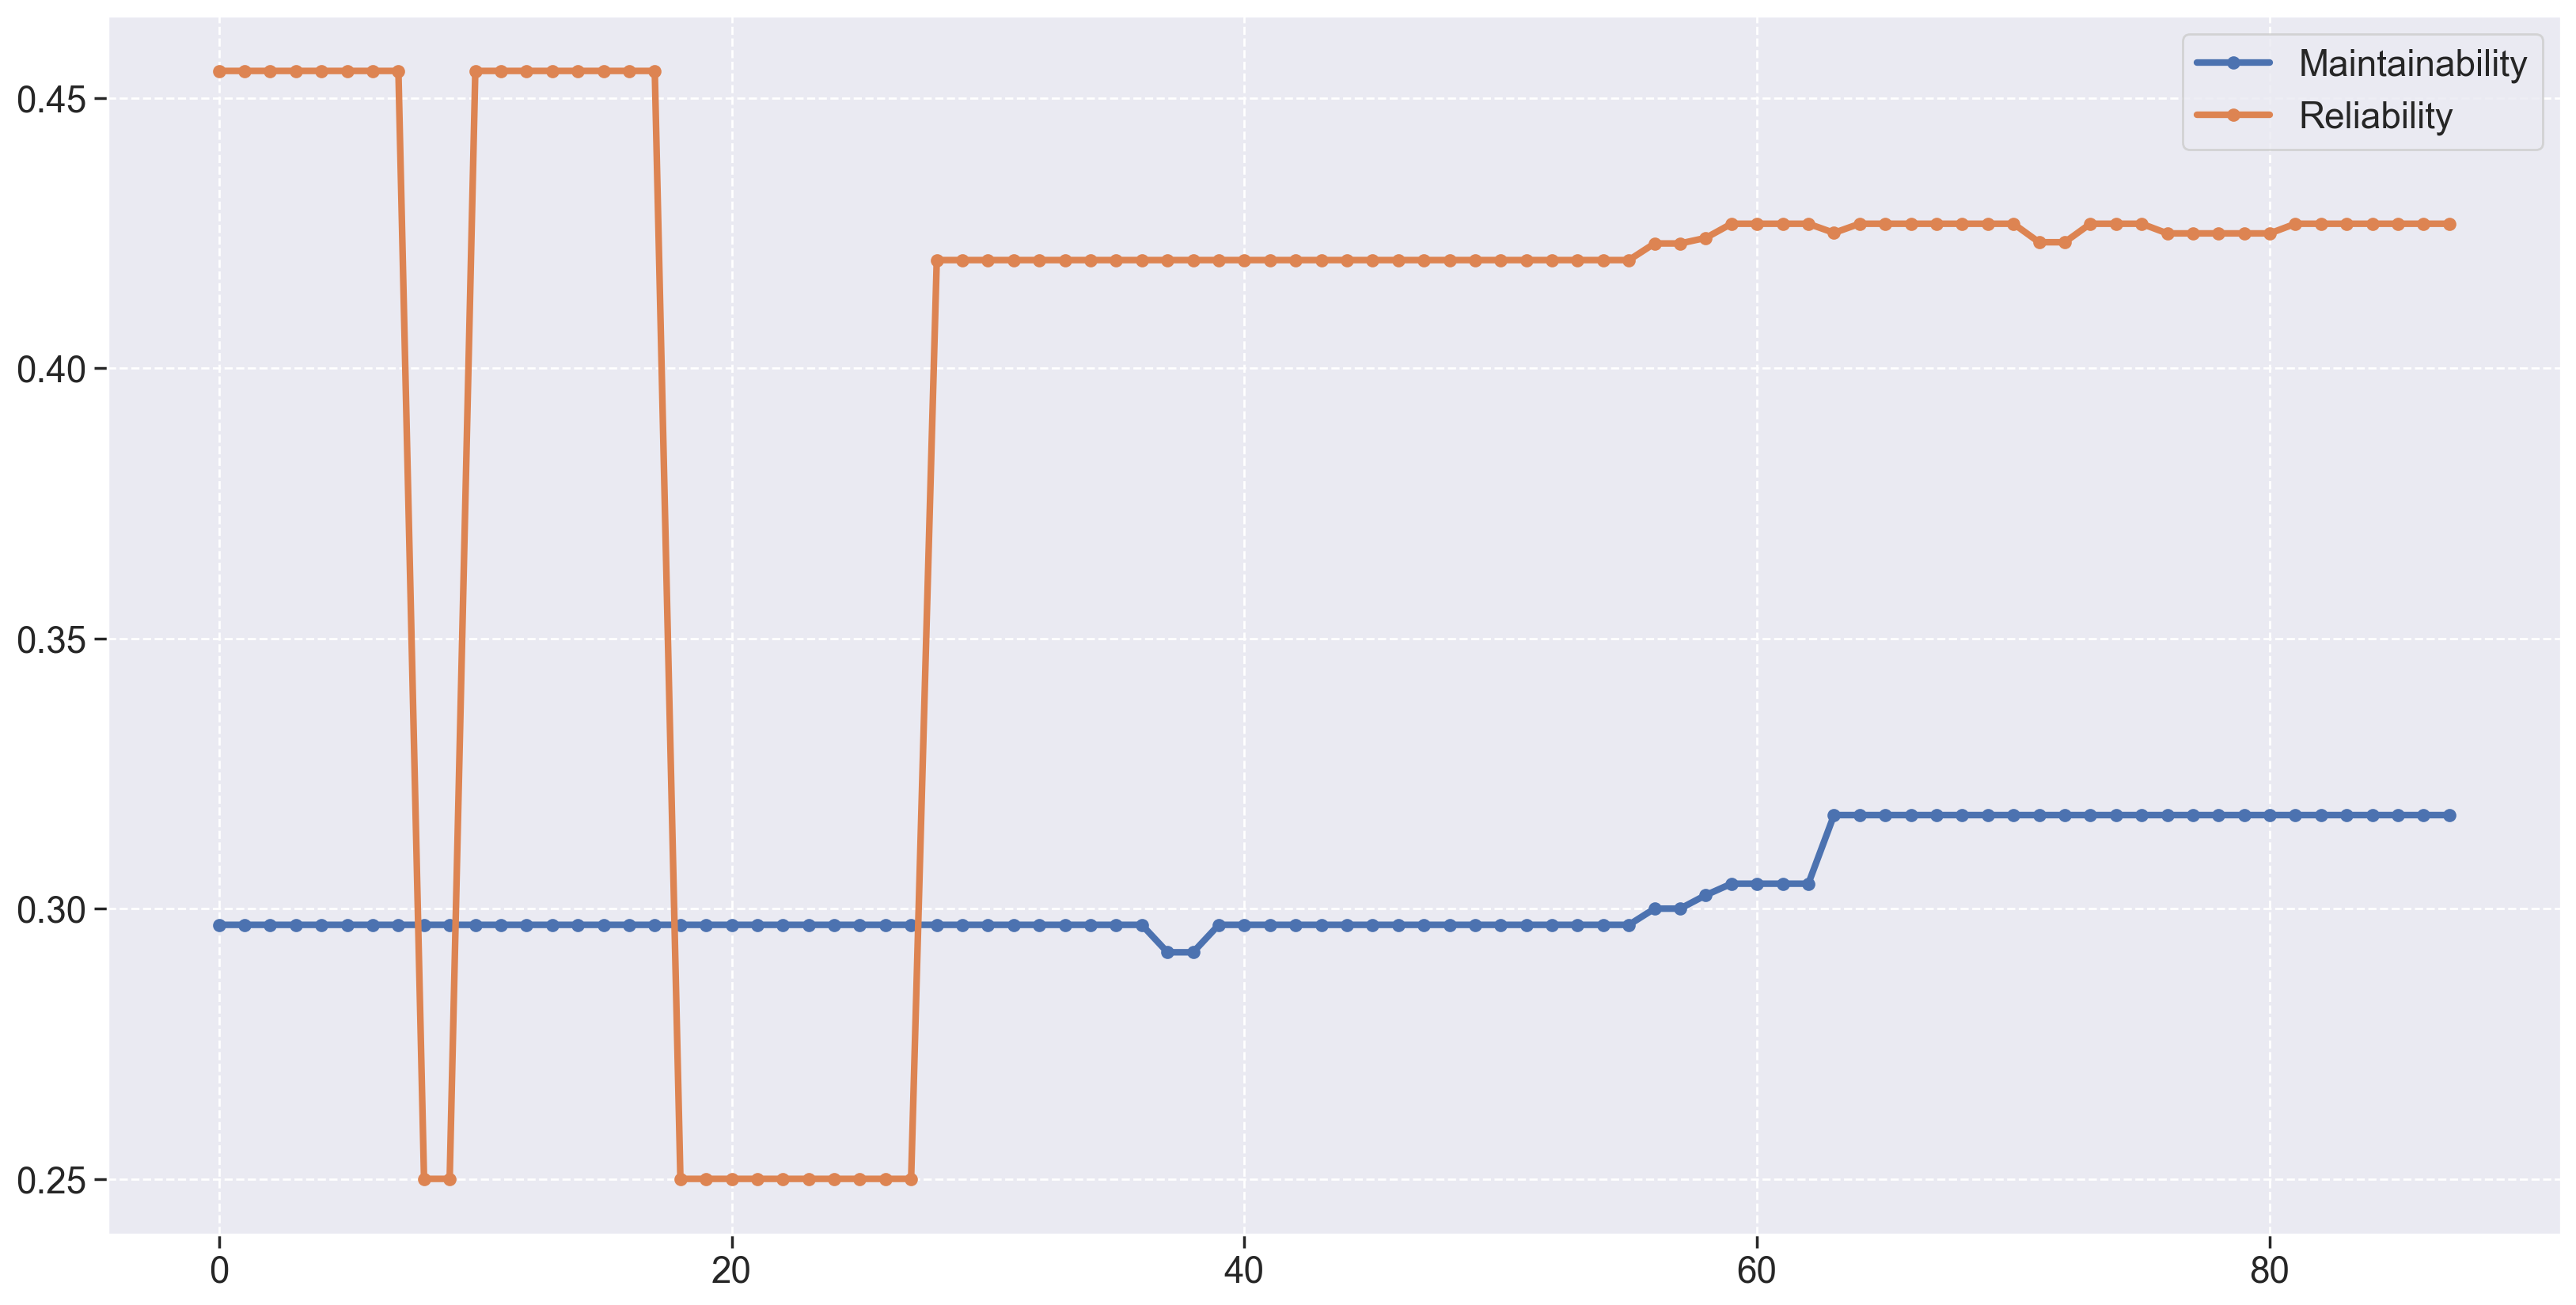

In [35]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
plt.plot(cli_metrics['Reliability'], linewidth=3, marker='o', markersize=5, label="Reliability")

plt.legend(loc='best')

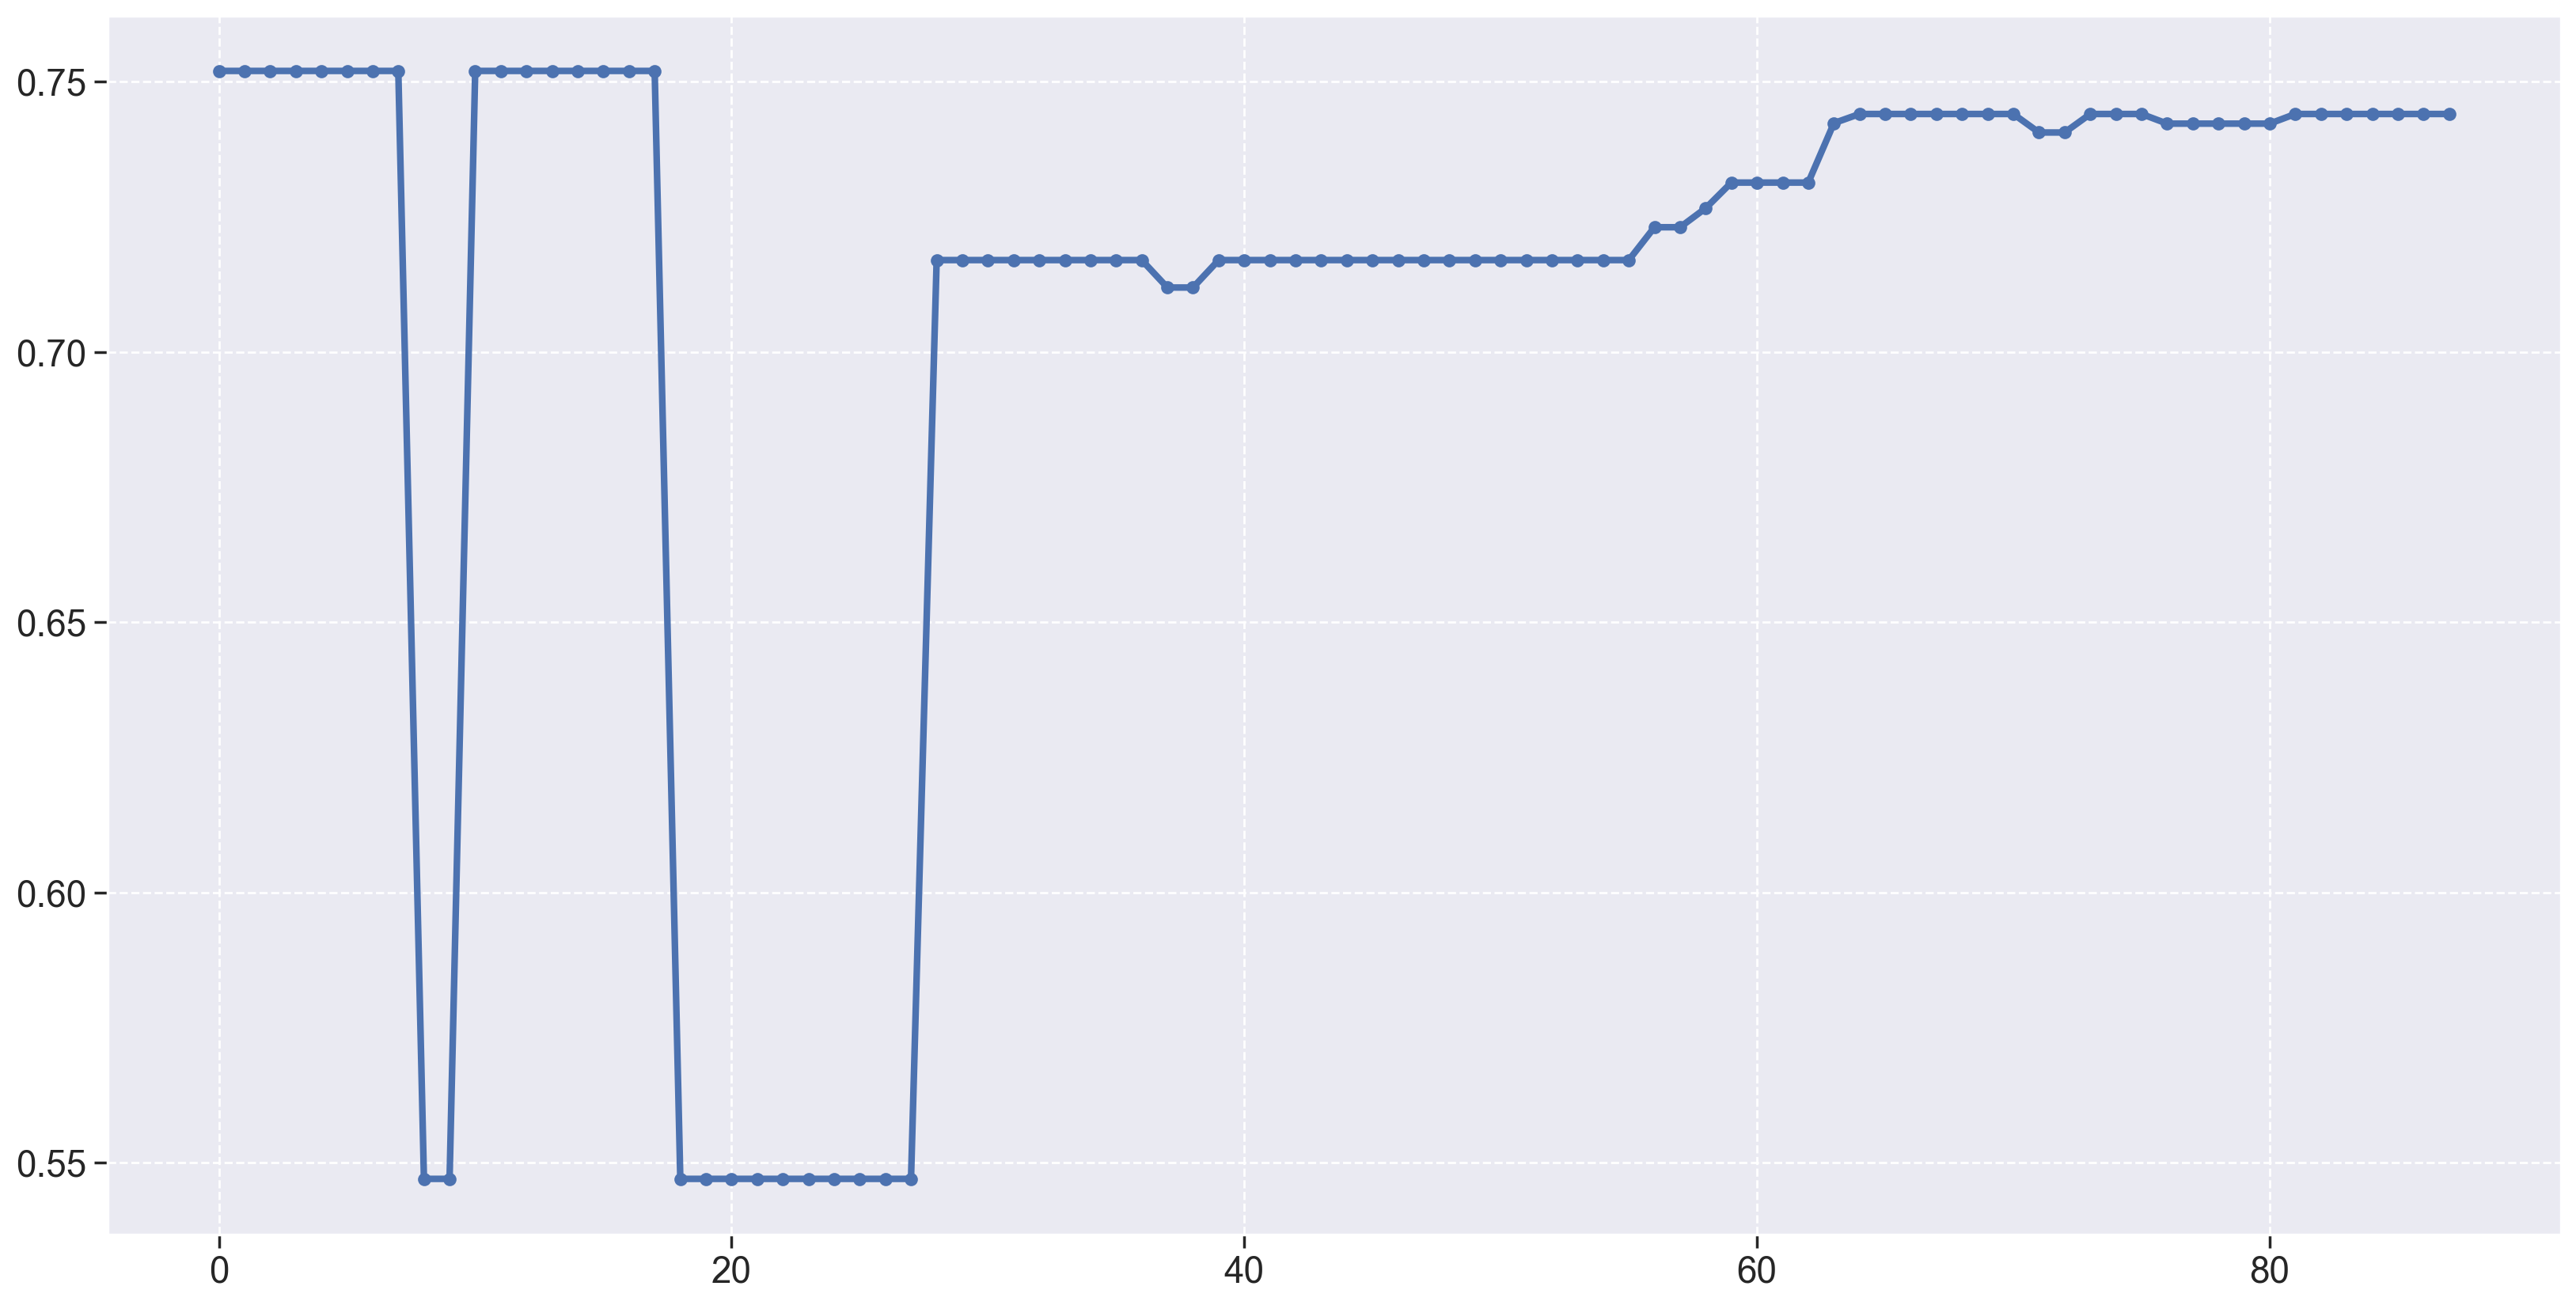

In [36]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['total'], linewidth=3, marker='o', markersize=5)

## Core Analysis

In [37]:
maintainability_stats = pd.DataFrame(get_characteristc_stats(core_metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(core_metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [38]:
print(maintainability_stats)

       mean      mode    median       std       var       min       max
0  0.299881  0.294643  0.294643  0.009238  0.000085  0.294643  0.318214


In [39]:
print(reliability_stats)

       mean      mode    median       std       var   min       max
0  0.390759  0.399038  0.399038  0.035129  0.001234  0.25  0.399038


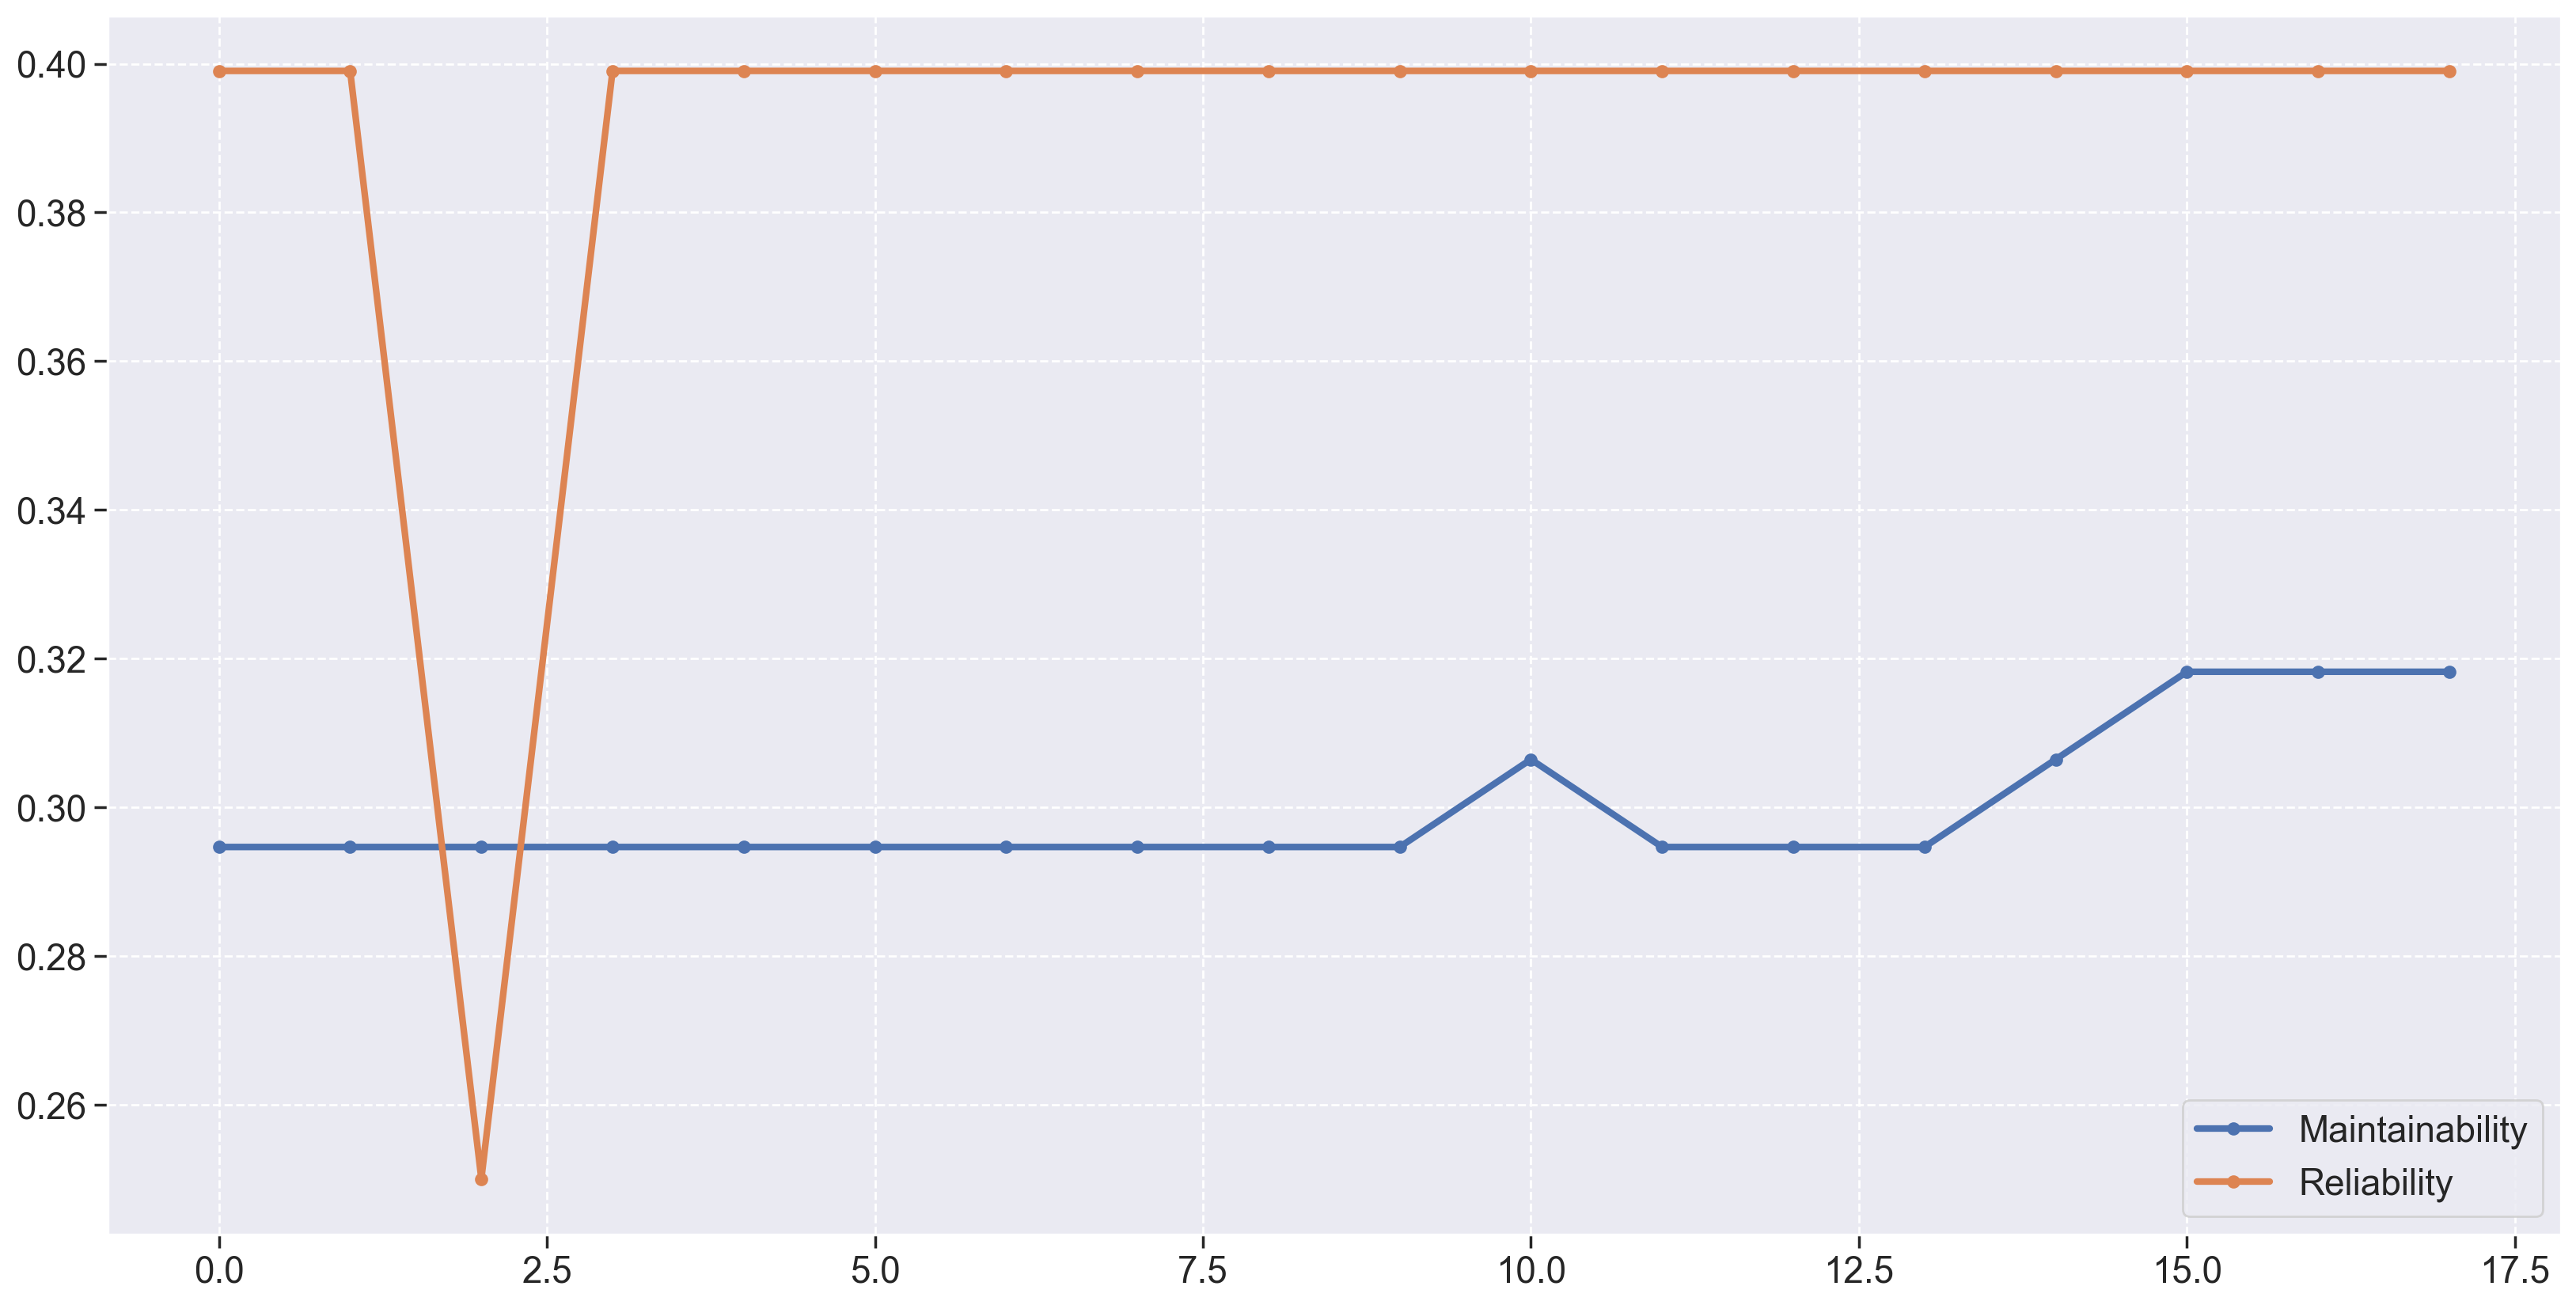

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.plot(core_metrics['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
plt.plot(core_metrics['Reliability'], linewidth=3, marker='o', markersize=5, label="Reliability")

plt.legend(loc='best')

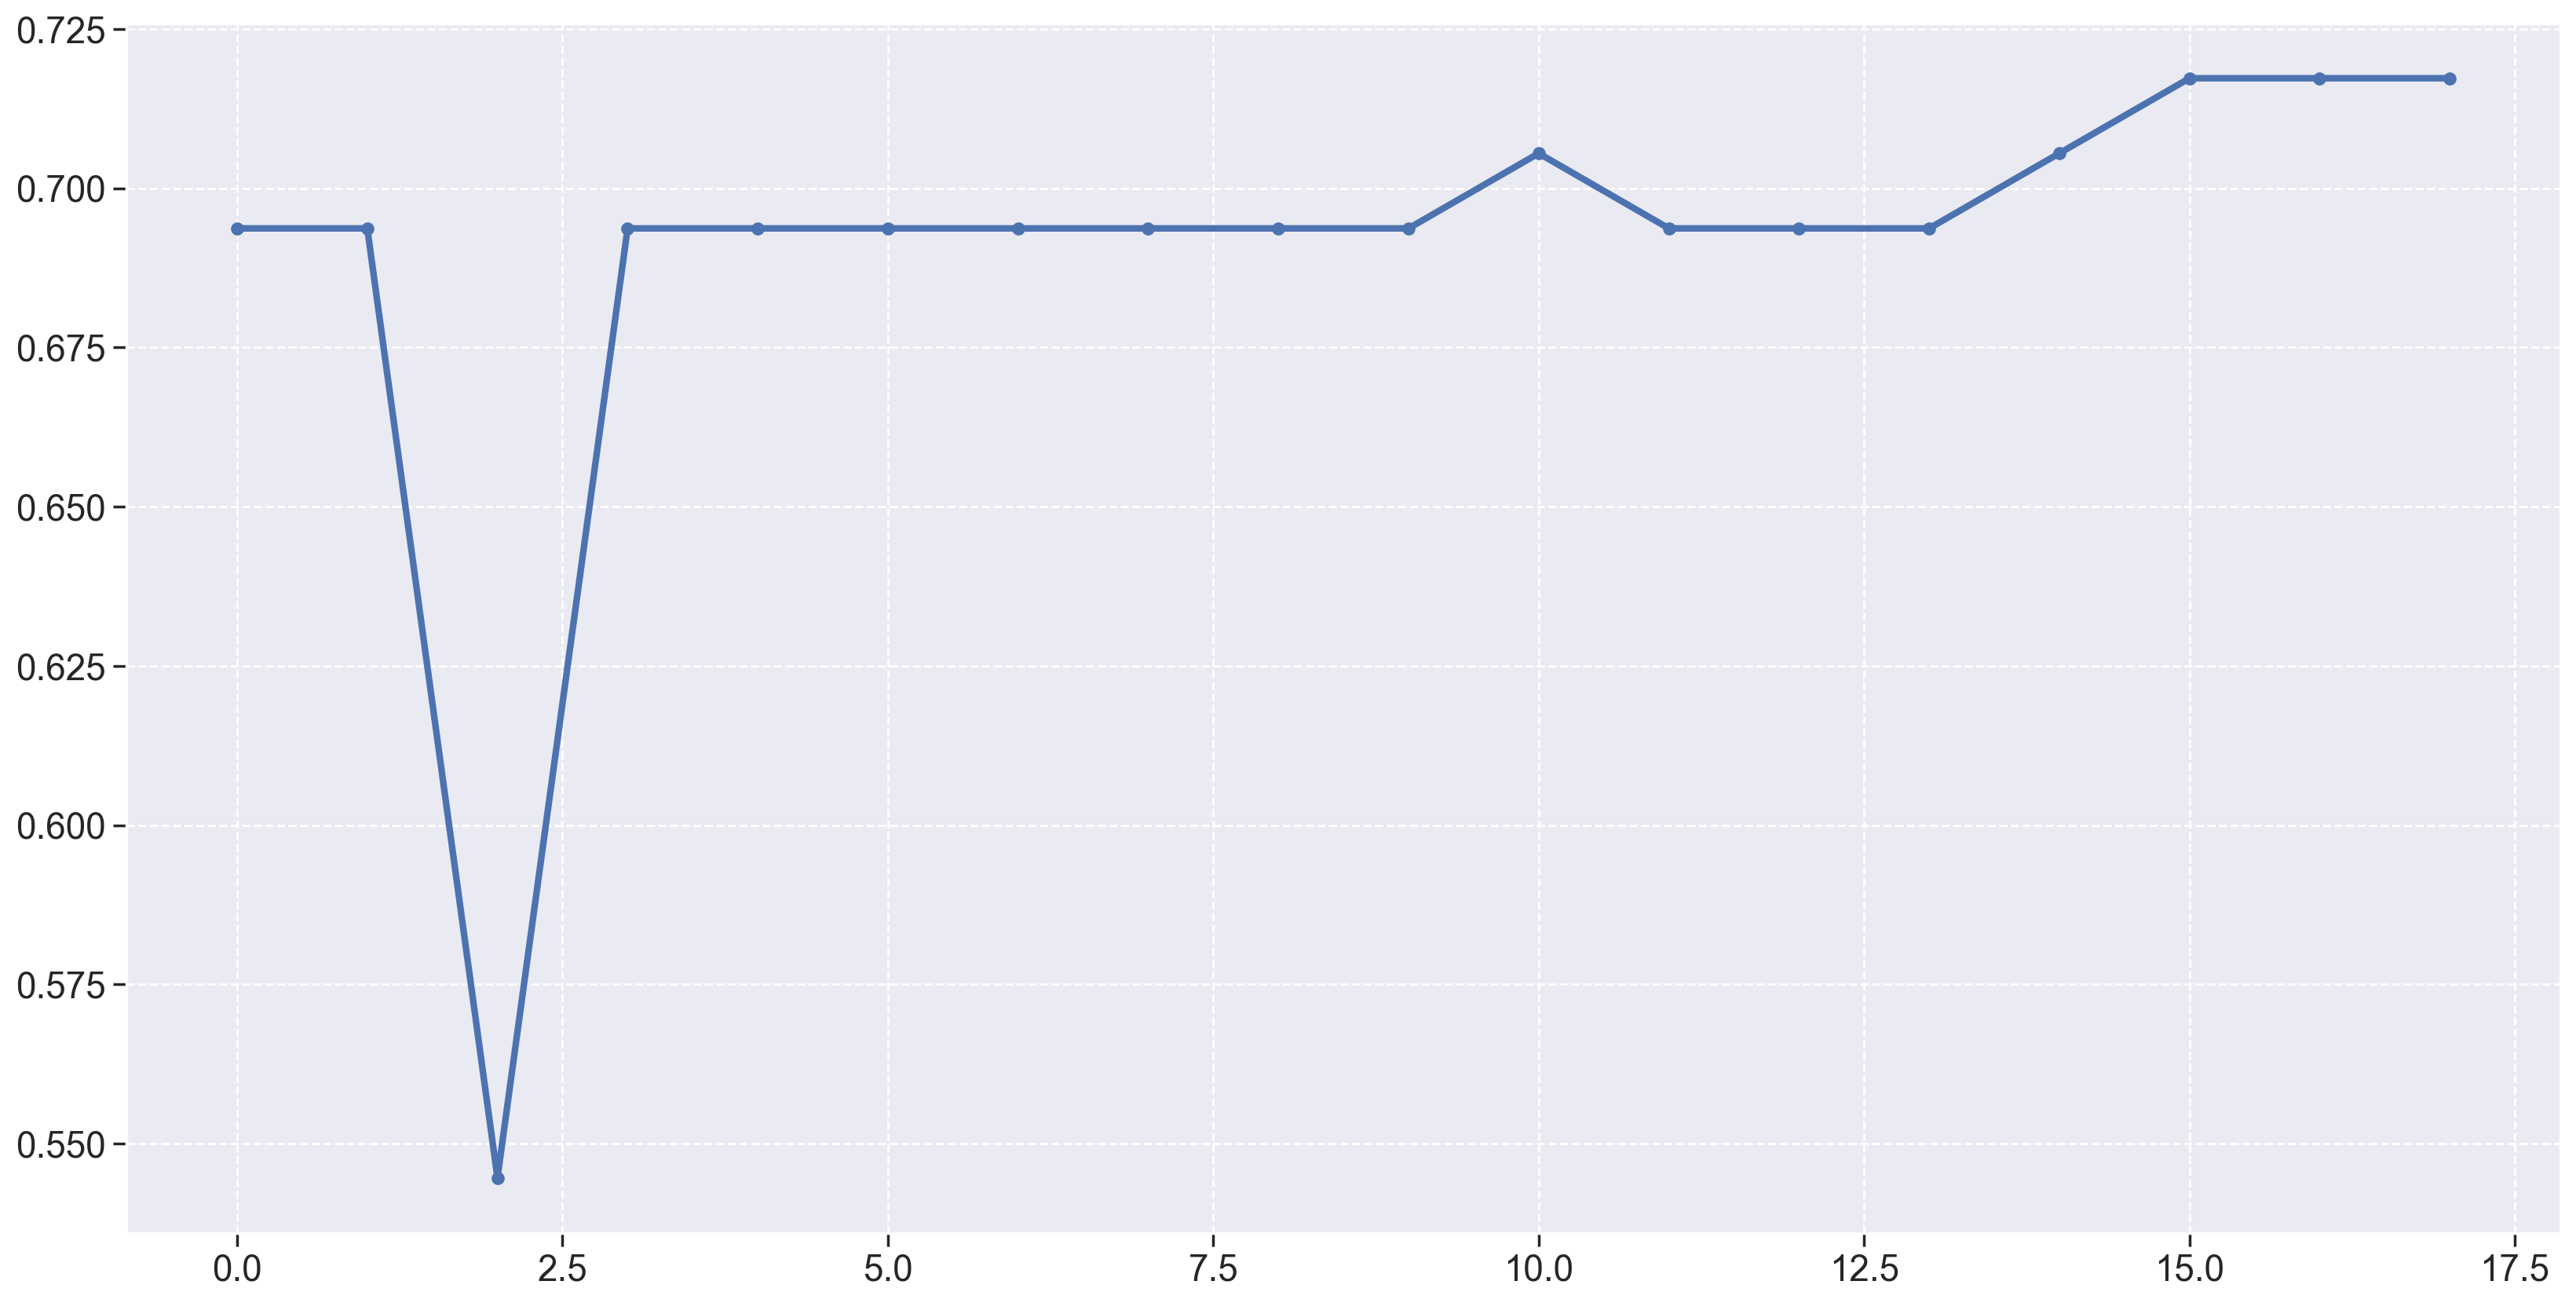

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.plot(core_metrics['total'], linewidth=3, marker='o', markersize=5)

## Dashboard Analysis

In [42]:
maintainability_stats = pd.DataFrame(get_characteristc_stats(front_metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(front_metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [43]:
print(maintainability_stats)

       mean    mode    median       std       var       min       max
0  0.286898  0.2915  0.289426  0.005162  0.000027  0.276618  0.291923


In [44]:
print(reliability_stats)

      mean  mode    median       std       var       min  max
0  0.49212   0.5  0.494186  0.008005  0.000064  0.479167  0.5


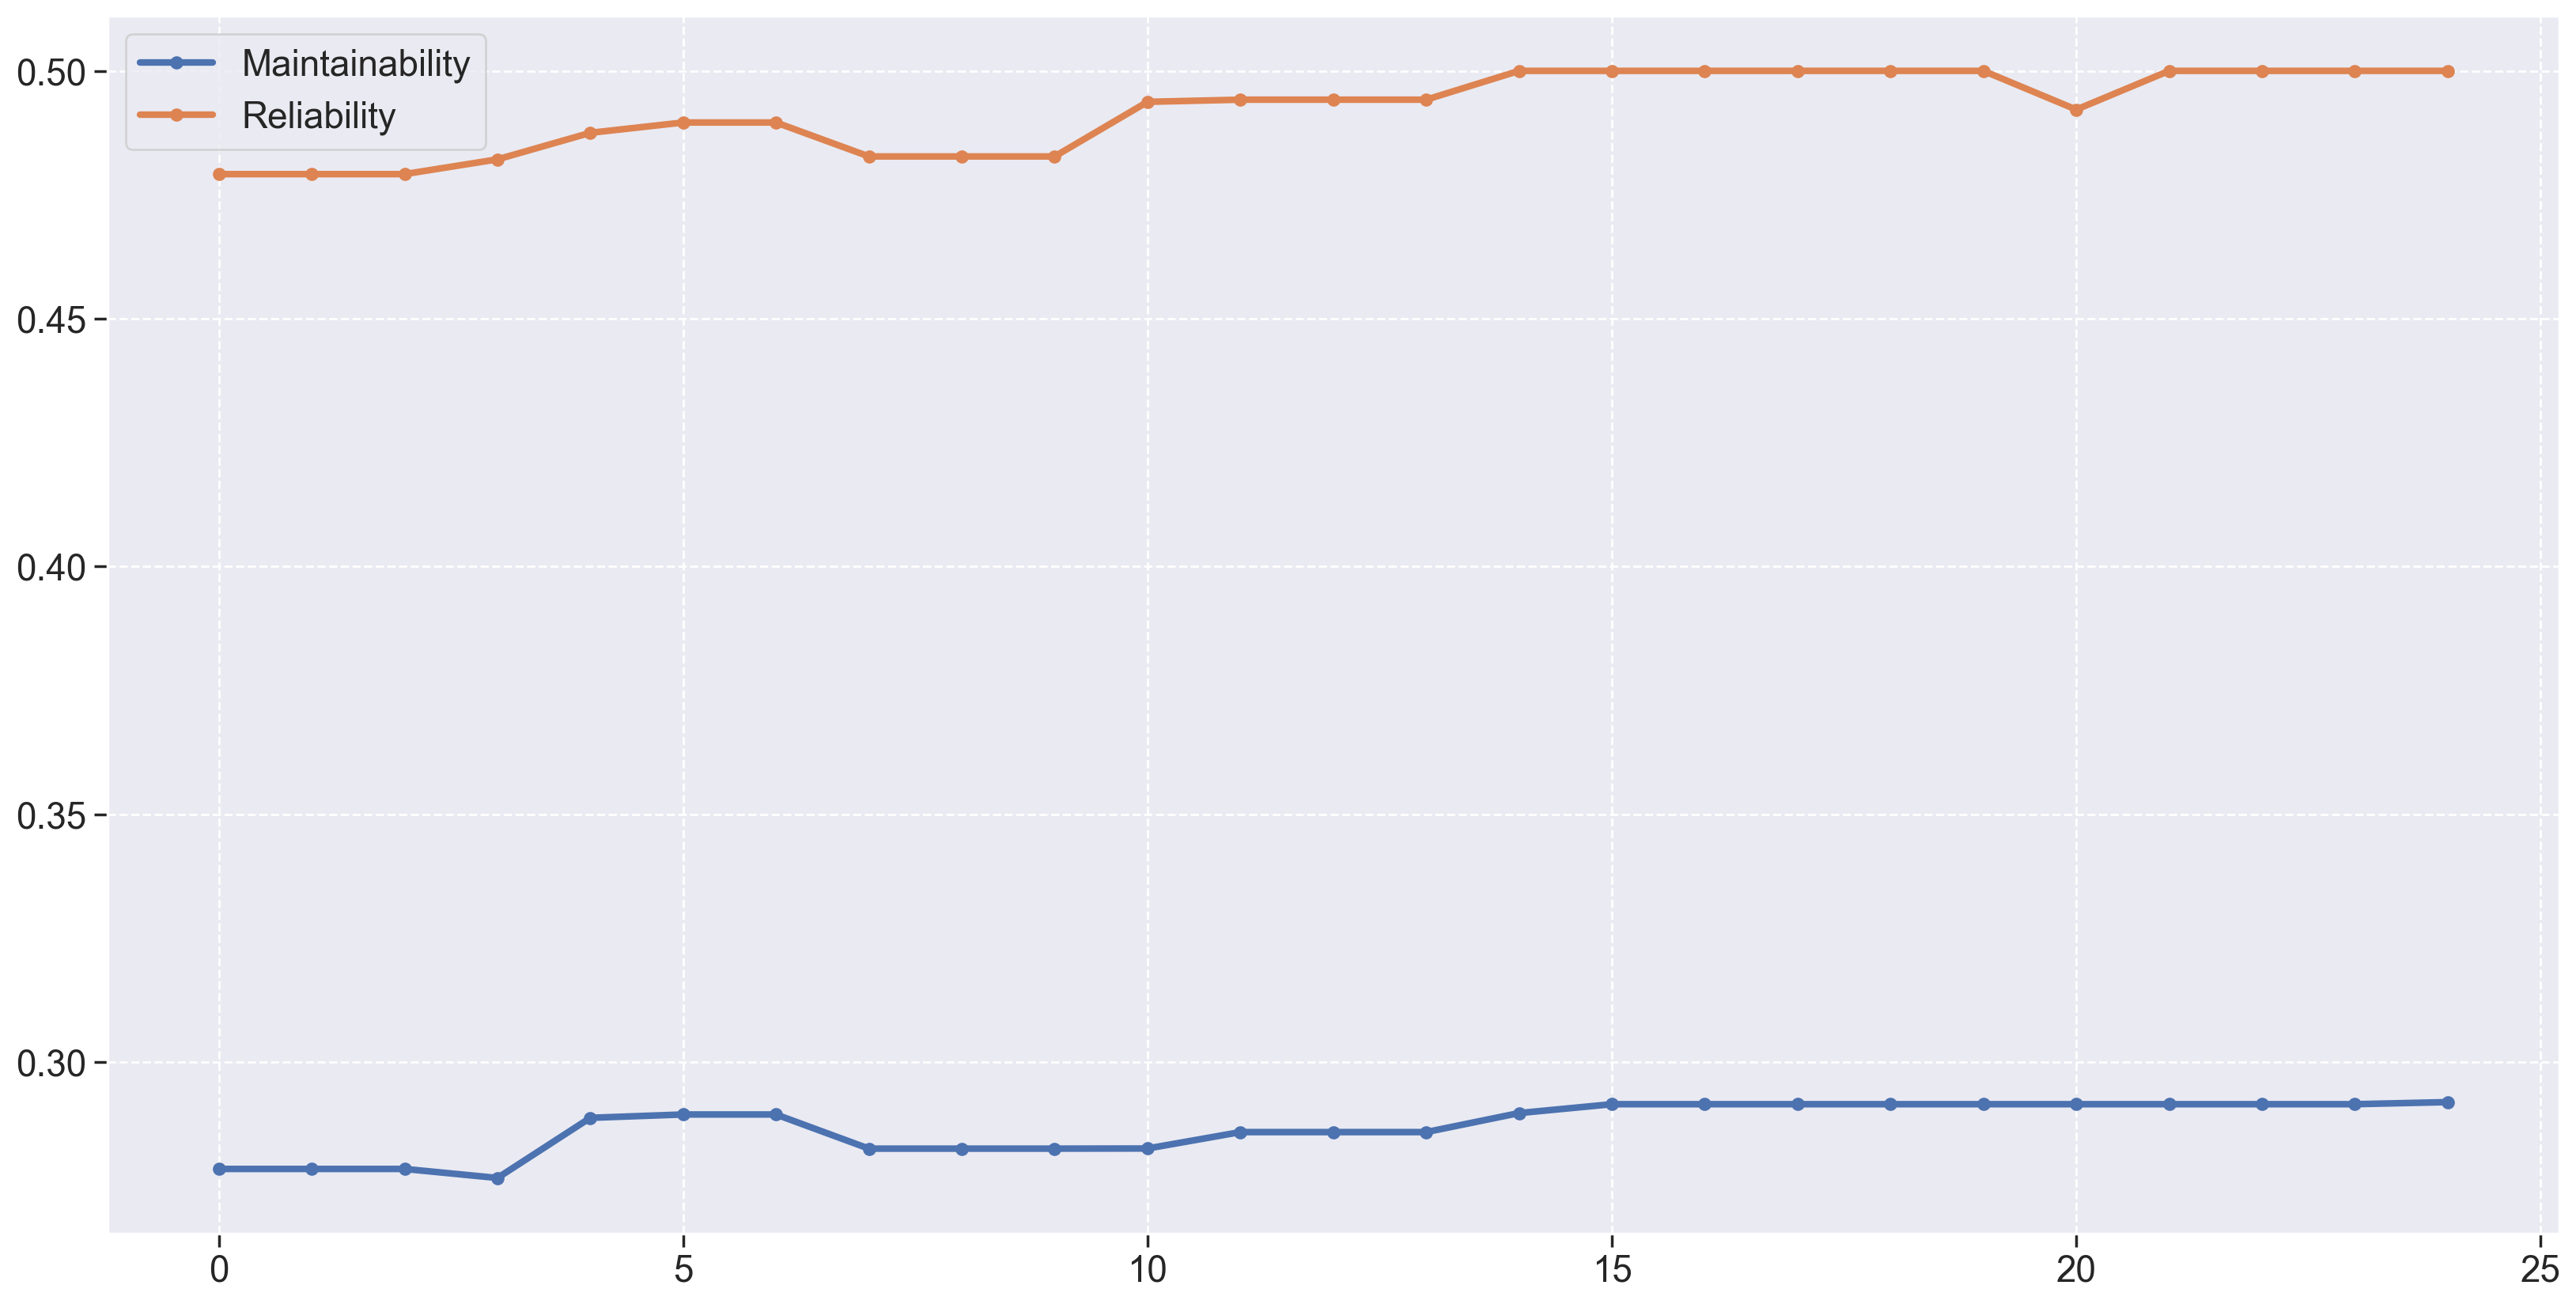

In [45]:
fig = plt.figure(figsize=(20, 10))

plt.plot(front_metrics['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
plt.plot(front_metrics['Reliability'], linewidth=3, marker='o', markersize=5, label="Reliability")

plt.legend(loc='best')

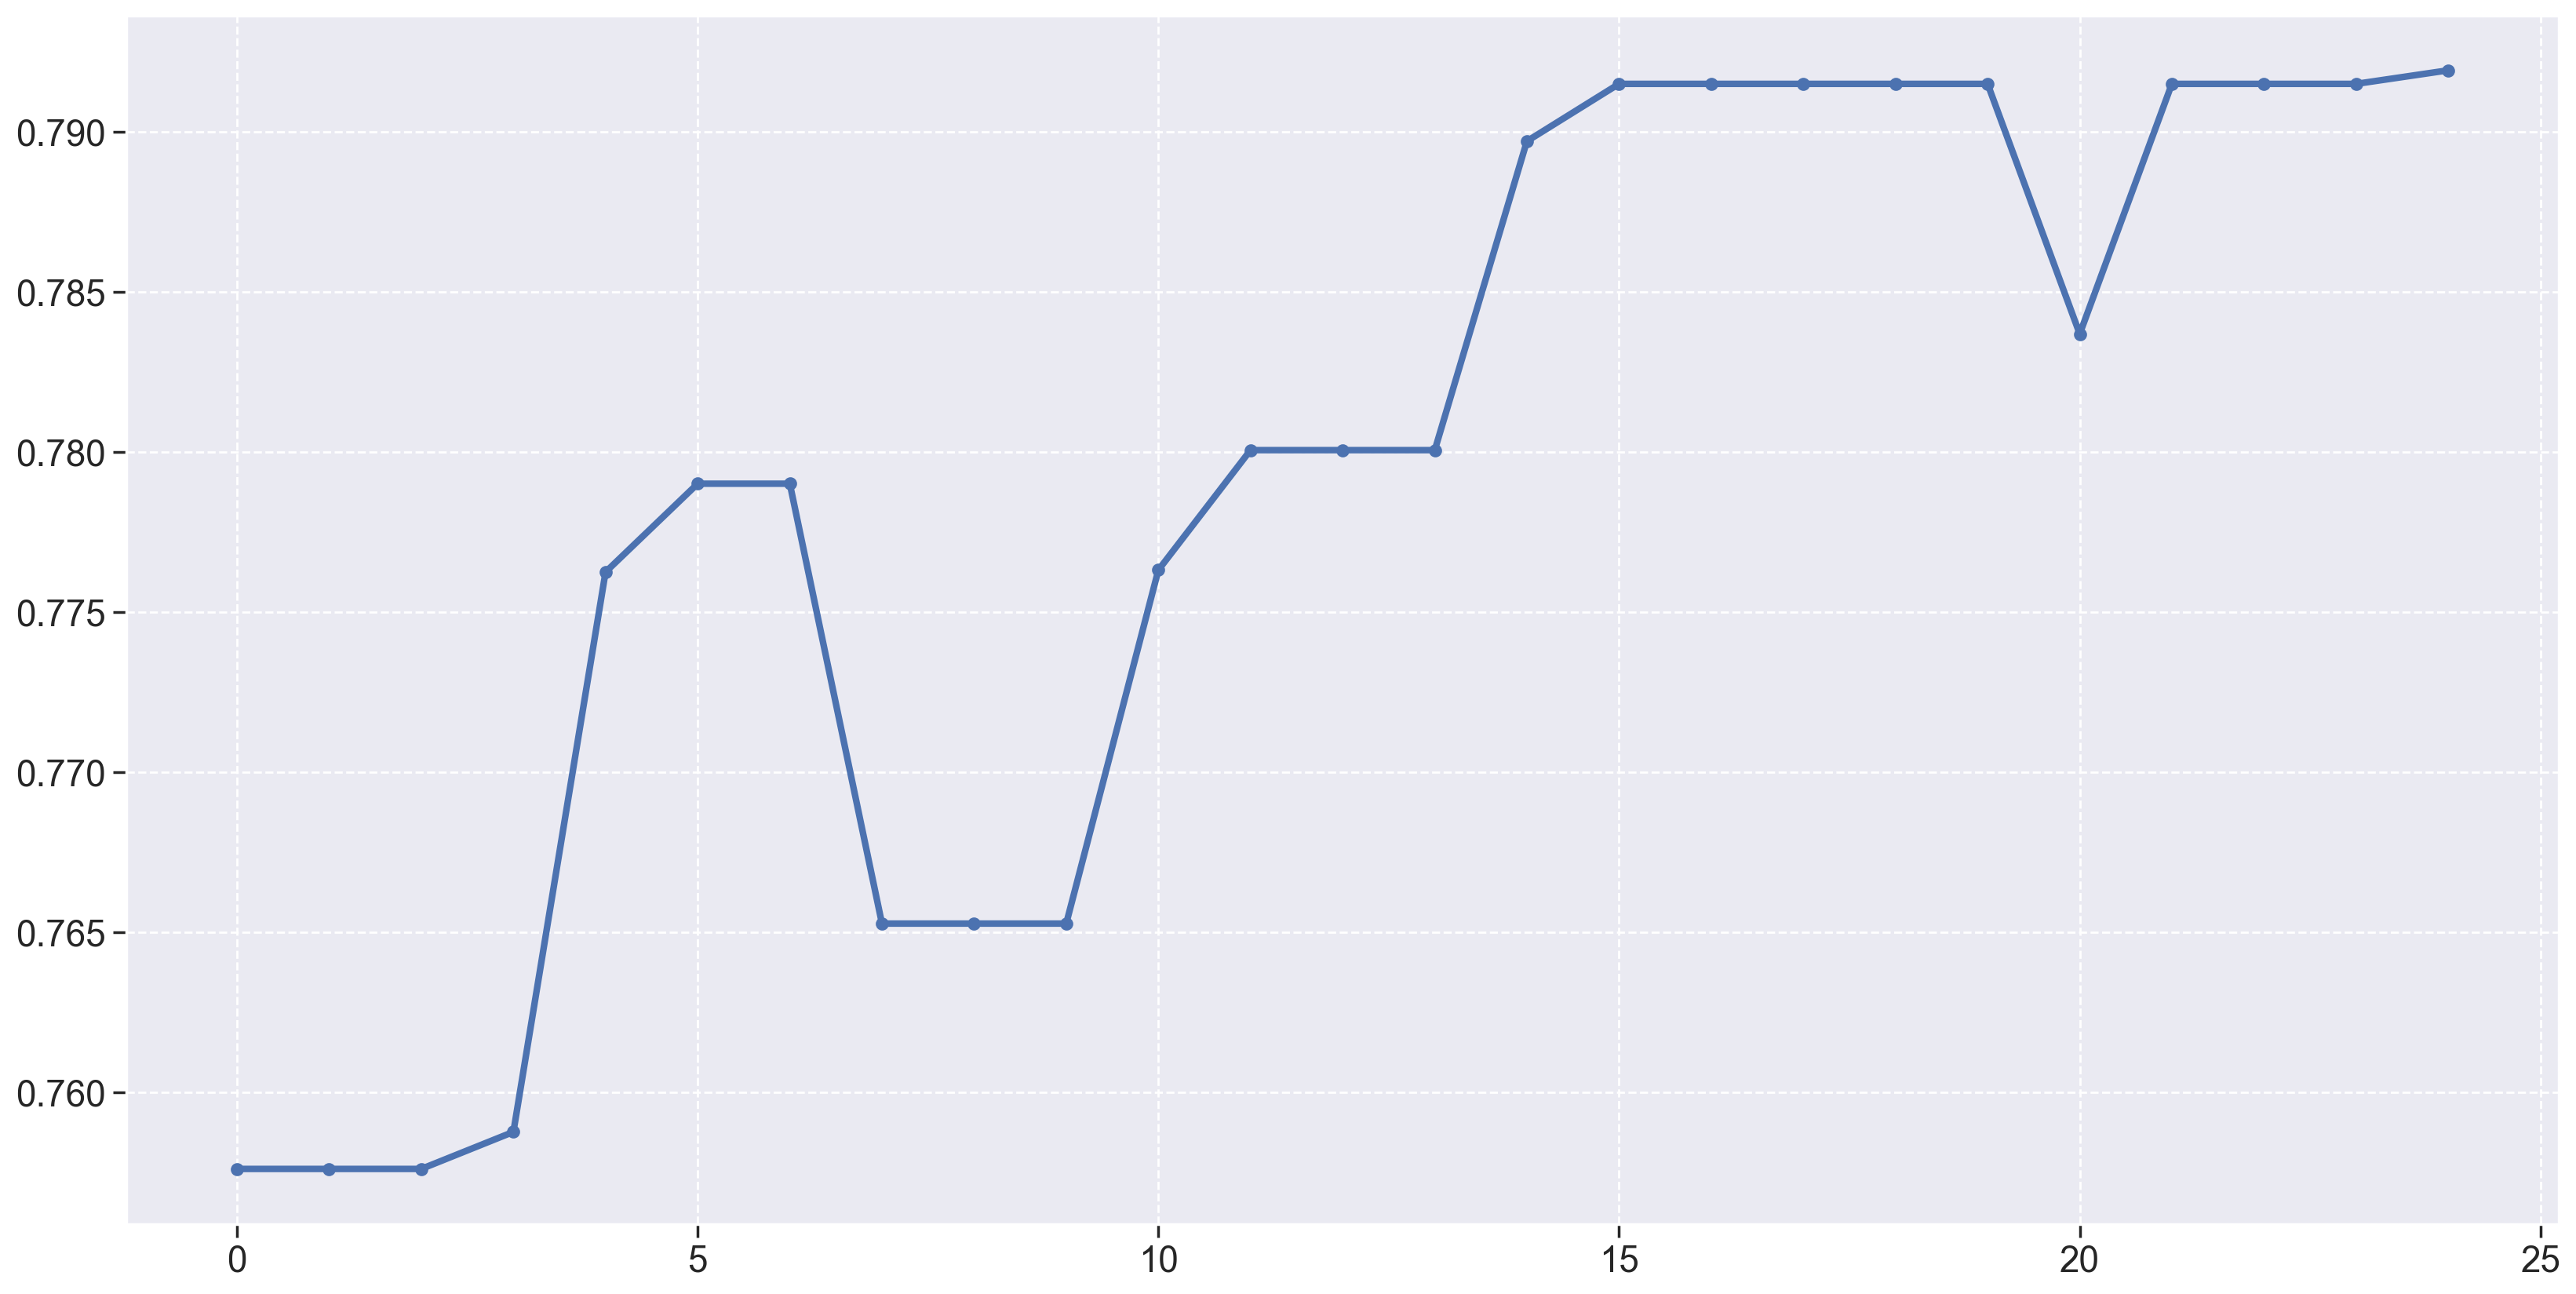

In [46]:
fig = plt.figure(figsize=(20, 10))

plt.plot(front_metrics['total'], linewidth=3, marker='o', markersize=5)

## Service Analysis

In [47]:
maintainability_stats = pd.DataFrame(get_characteristc_stats(service_metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(service_metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [48]:
print(maintainability_stats)

       mean      mode    median       std       var    min       max
0  0.276519  0.297363  0.272243  0.016708  0.000279  0.242  0.297363


In [49]:
print(reliability_stats)

   mean  mode  median  std  var   min   max
0  0.25  0.25    0.25  0.0  0.0  0.25  0.25


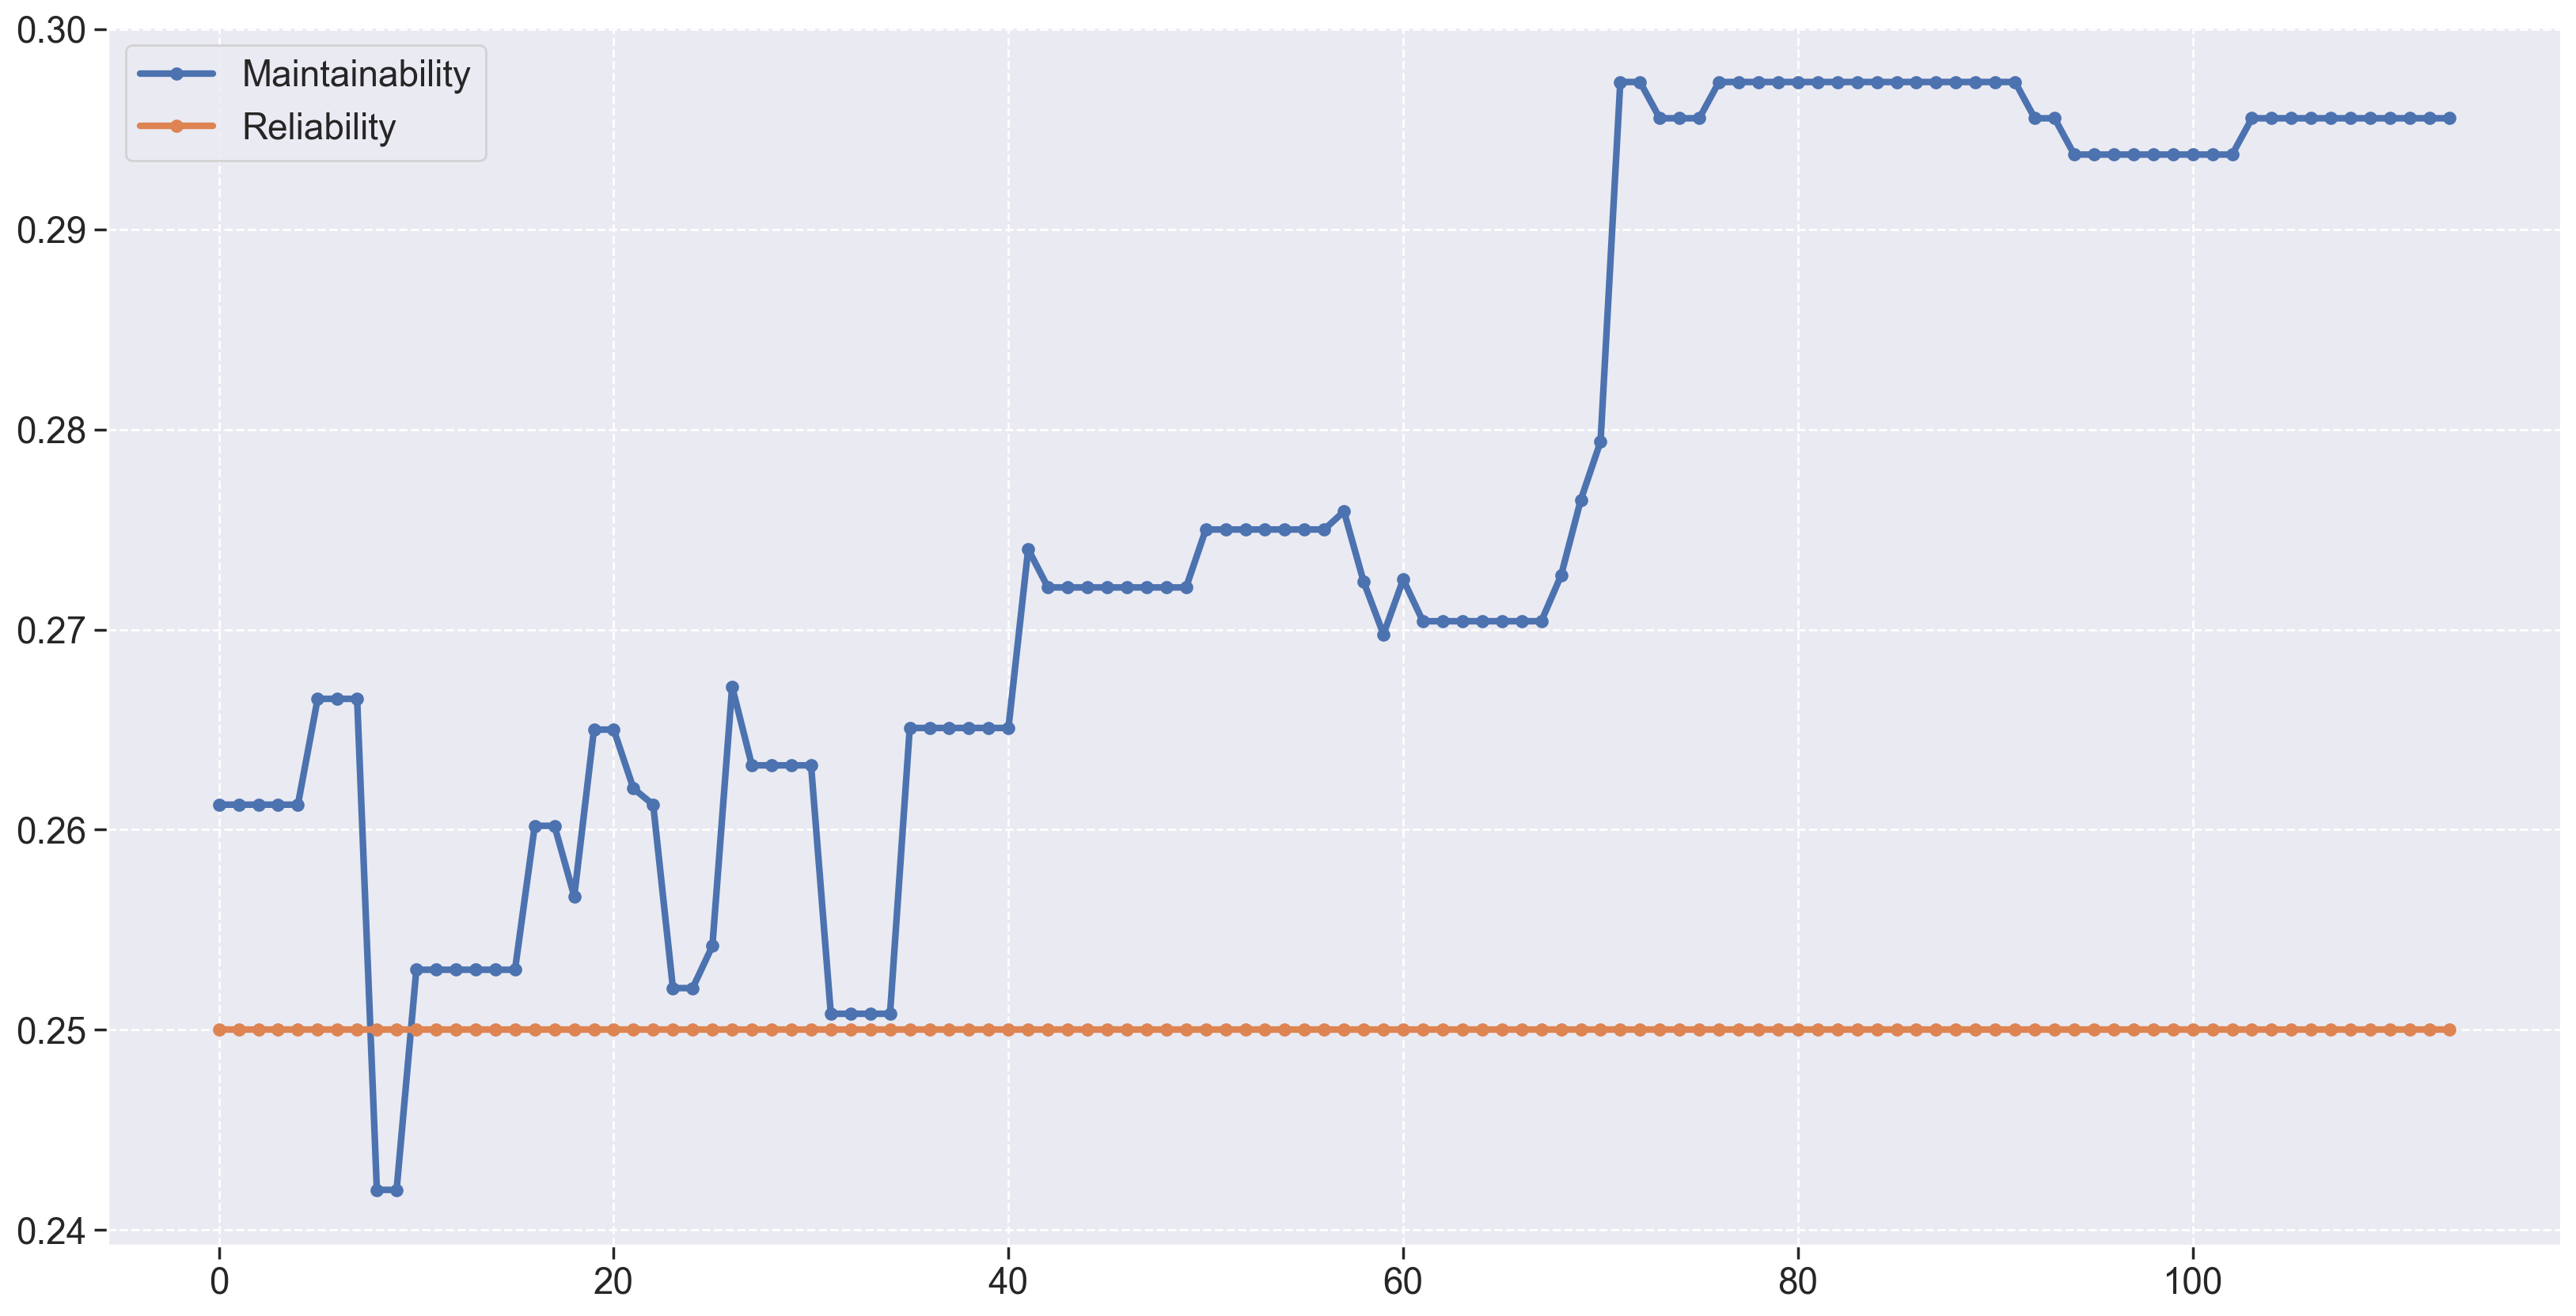

In [50]:
fig = plt.figure(figsize=(20, 10))

plt.plot(service_metrics['Maintainability'], linewidth=3, marker='o', markersize=5, label="Maintainability")
plt.plot(service_metrics['Reliability'], linewidth=3, marker='o', markersize=5, label="Reliability")

plt.legend(loc='best')

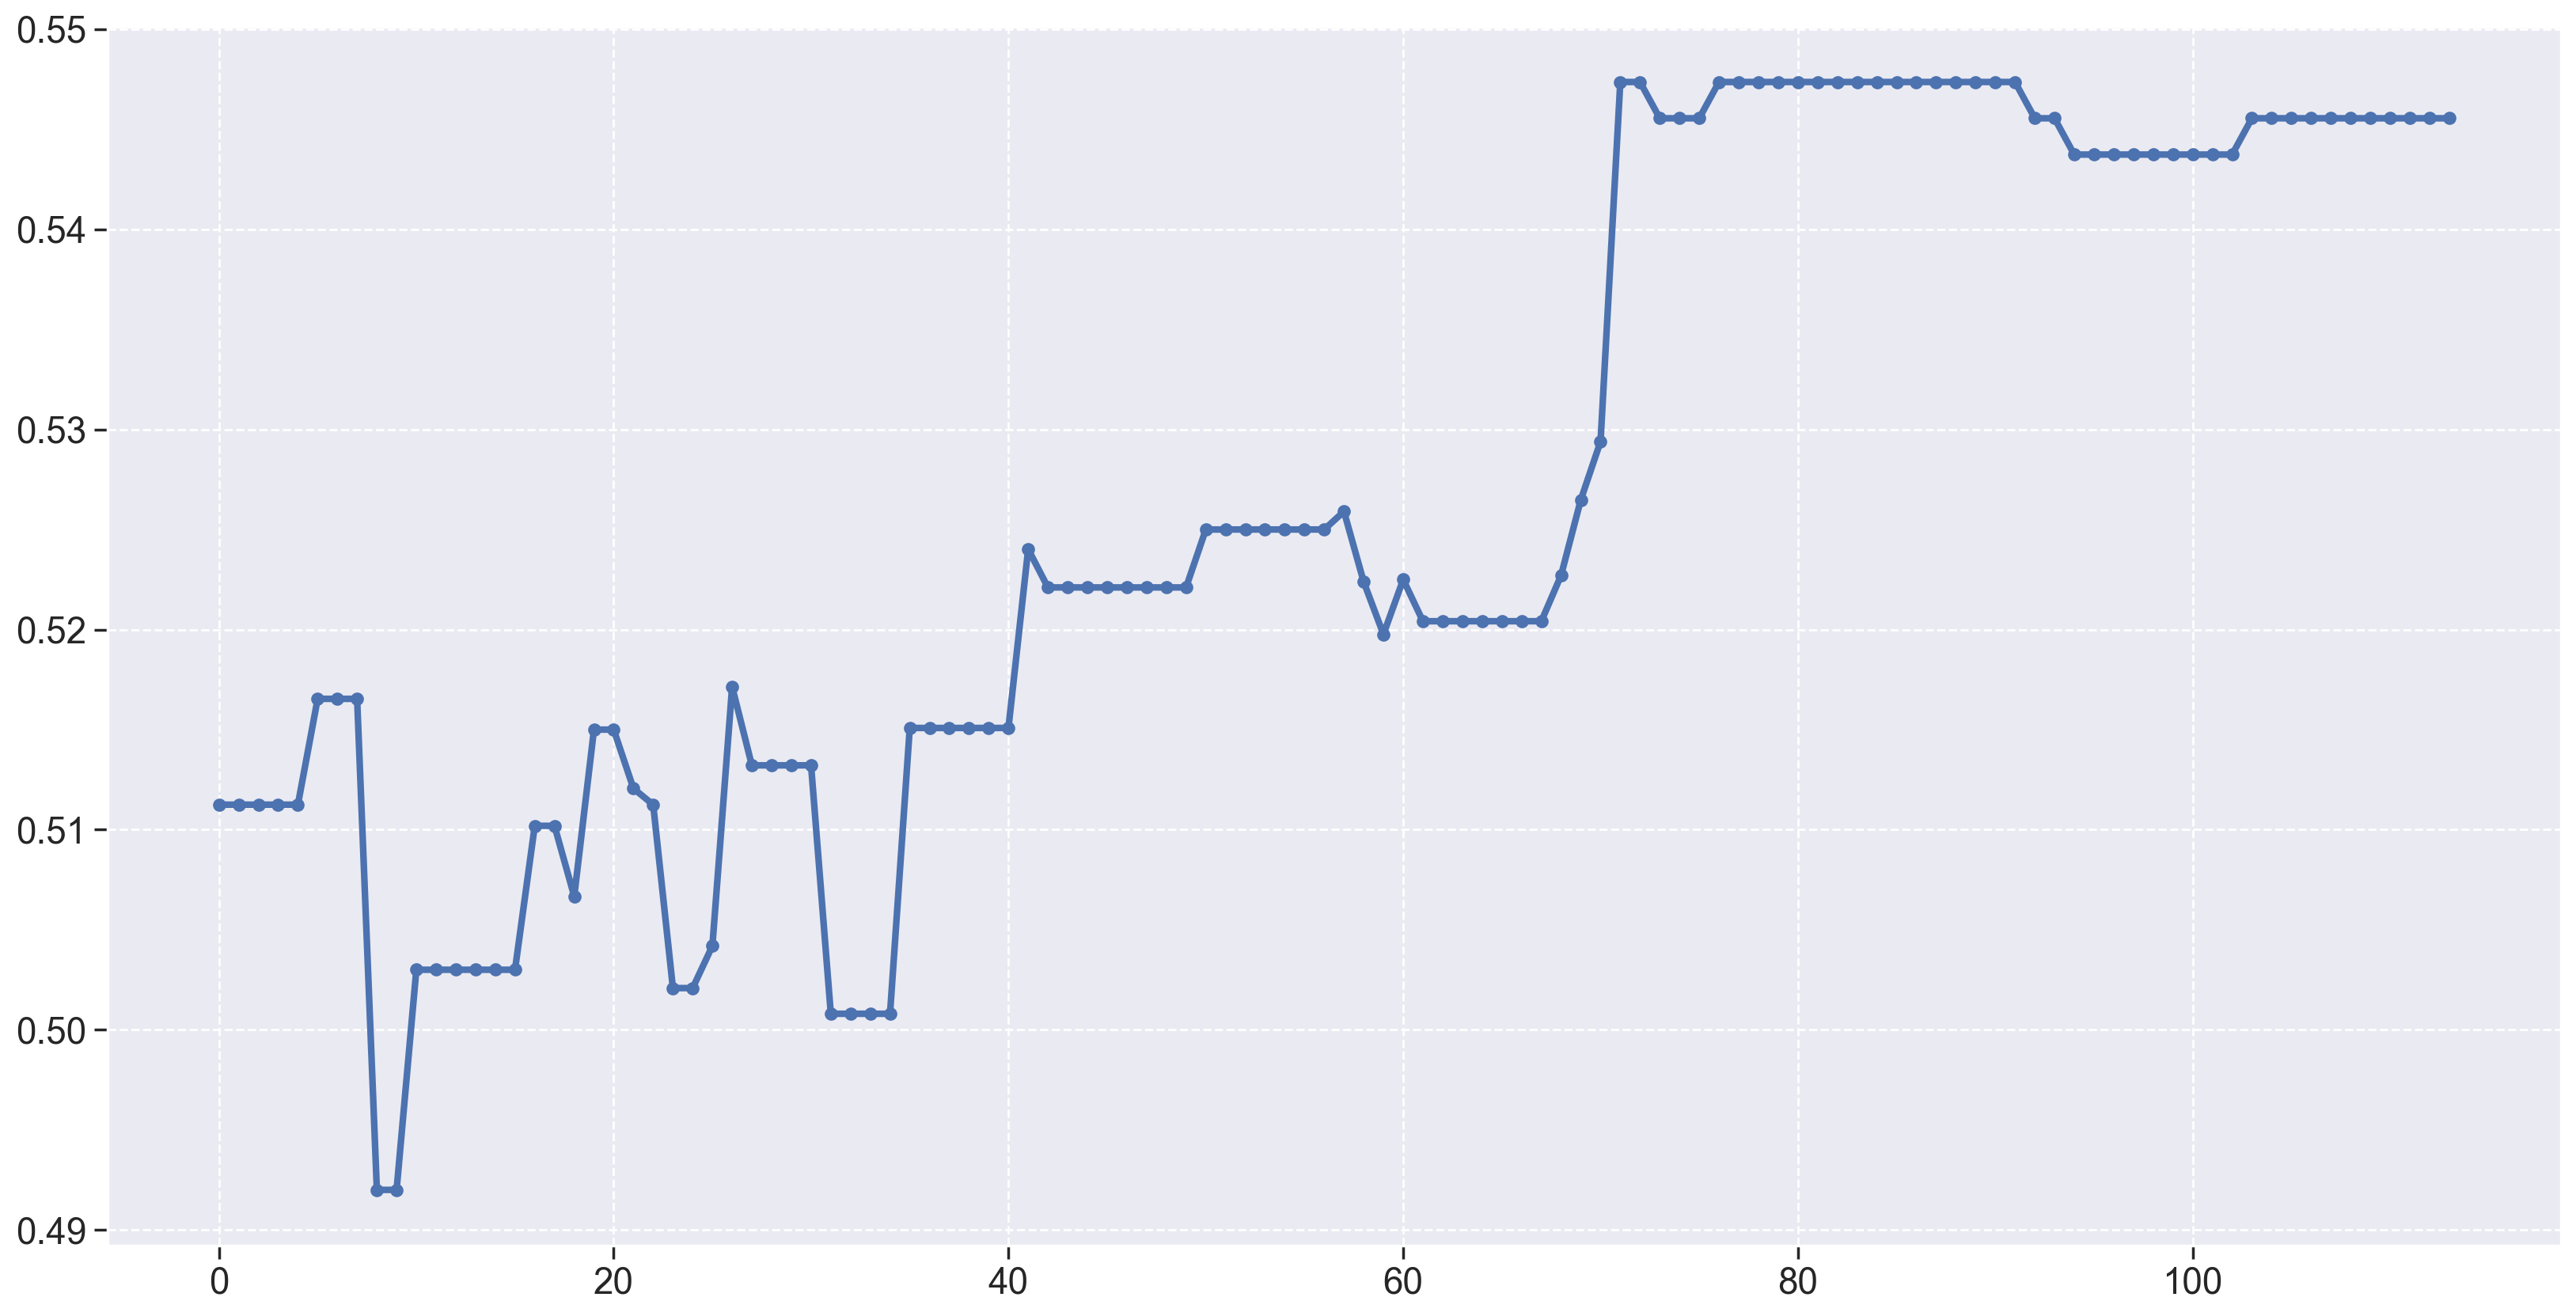

In [51]:
fig = plt.figure(figsize=(20, 10))

plt.plot(service_metrics['total'], linewidth=3, marker='o', markersize=5)

## Quality indicator visualization

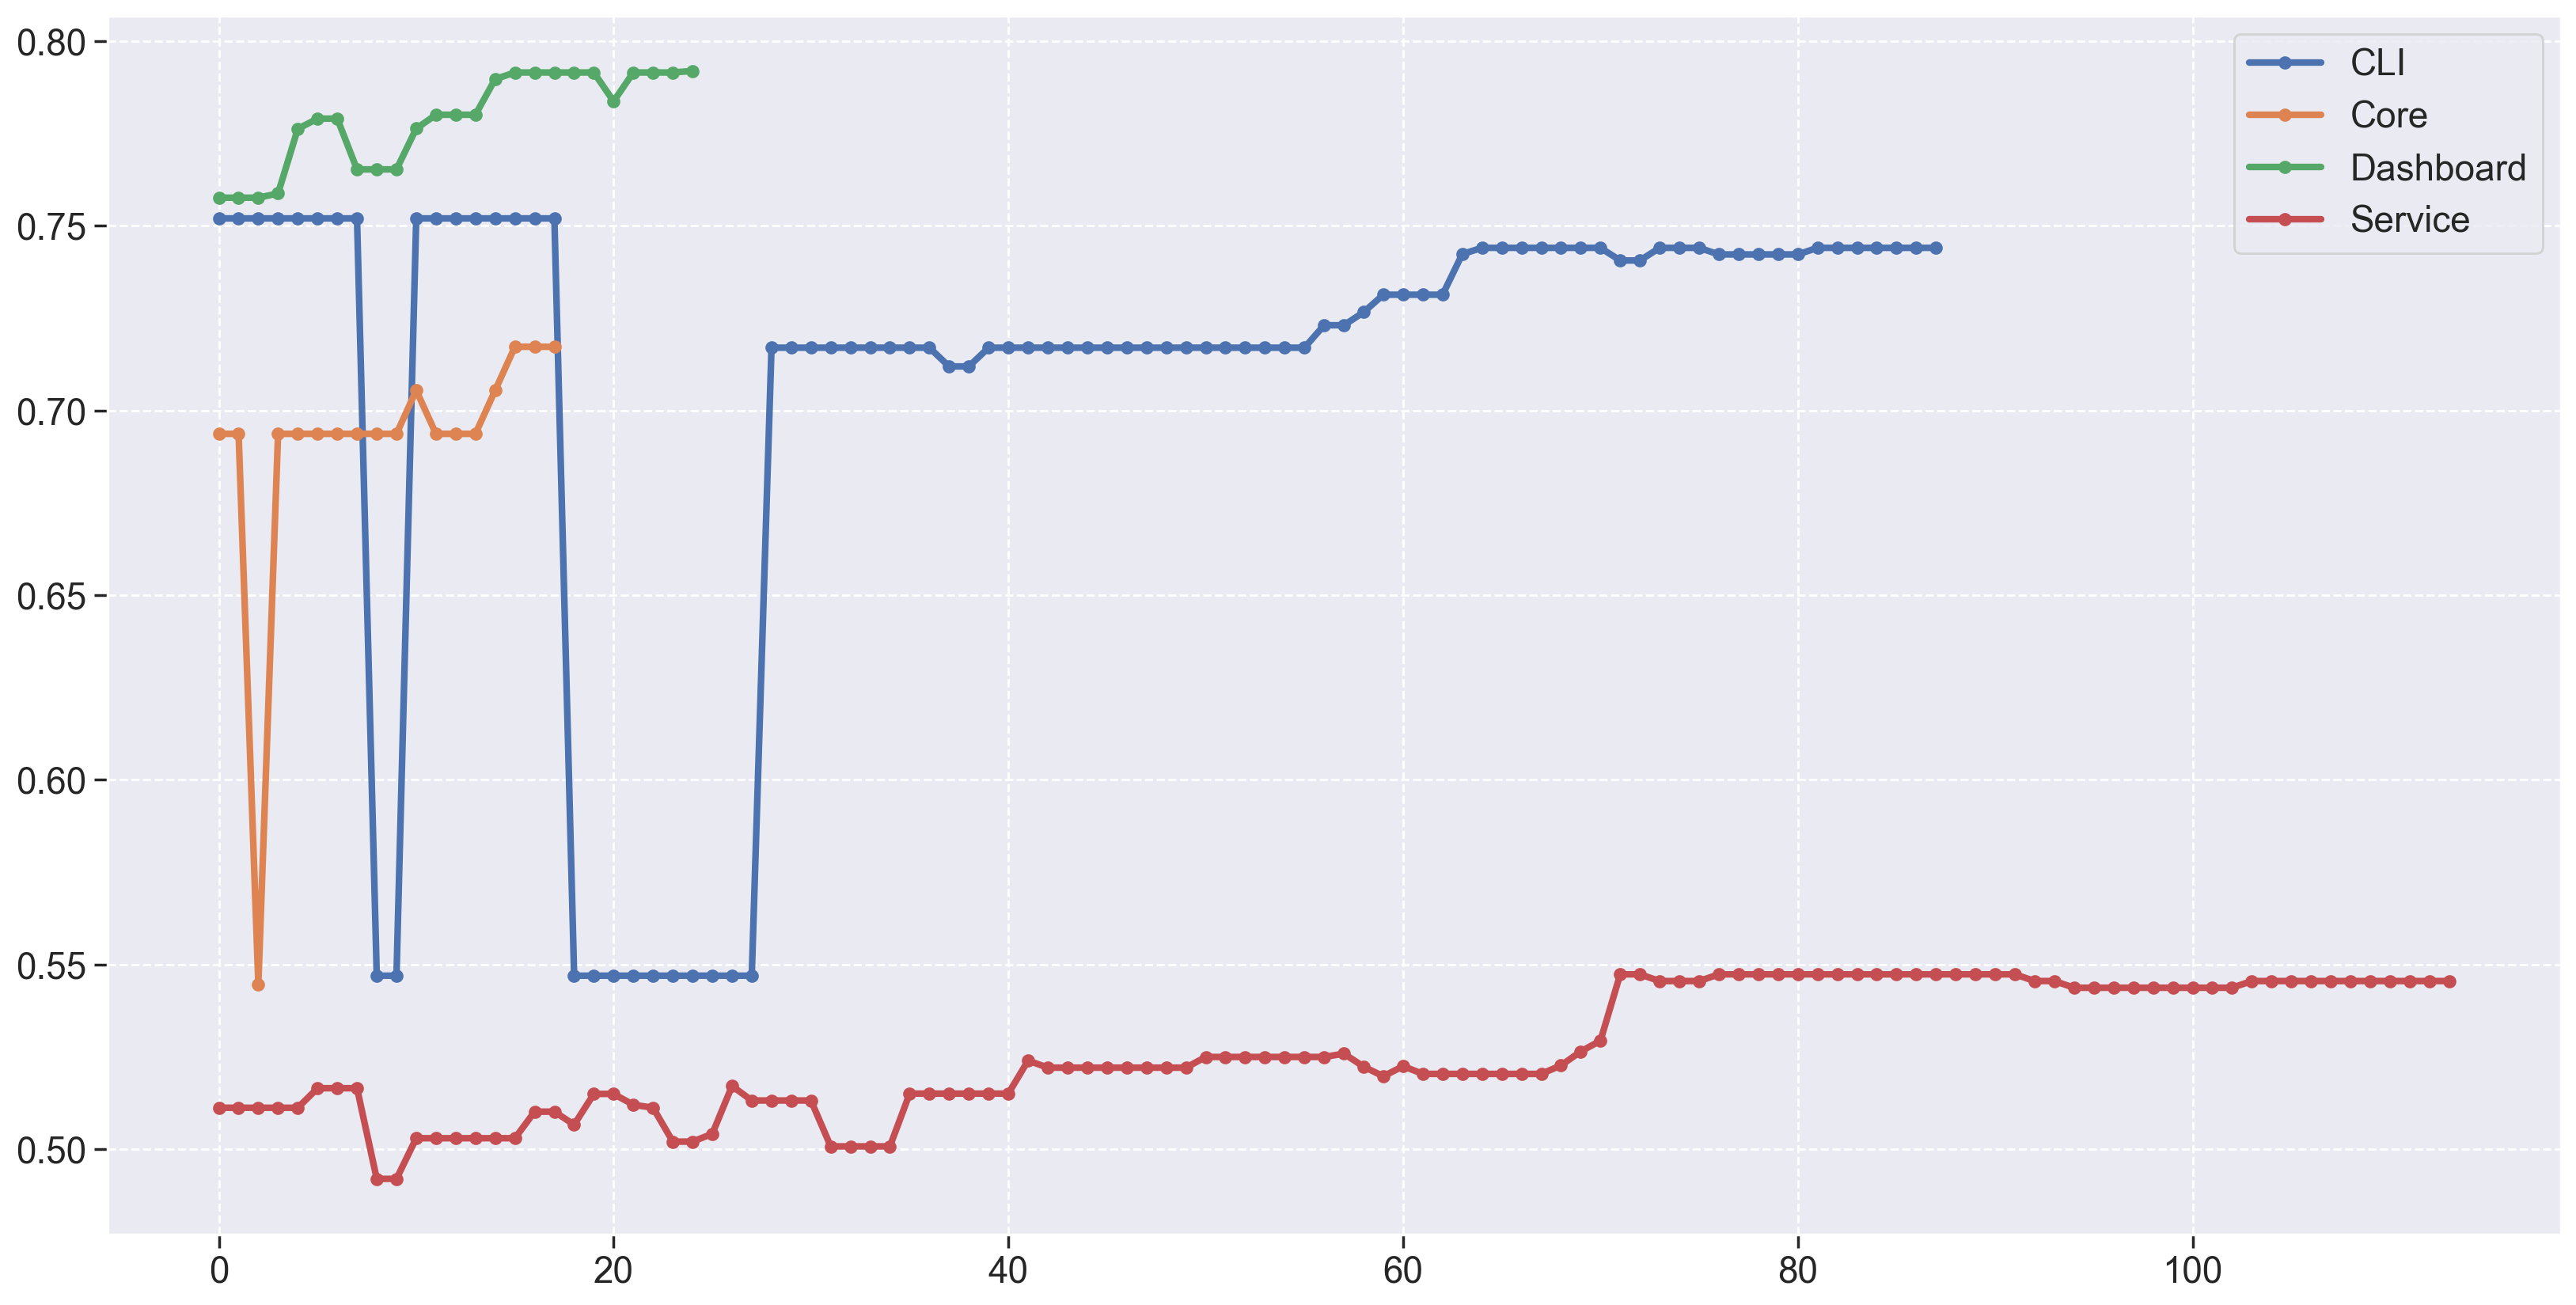

In [52]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['total'], linewidth=3, marker='o', markersize=5, label="CLI")
plt.plot(core_metrics['total'], linewidth=3, marker='o', markersize=5, label="Core")
plt.plot(front_metrics['total'], linewidth=3, marker='o', markersize=5, label="Dashboard")
plt.plot(service_metrics['total'], linewidth=3, marker='o', markersize=5, label="Service")

plt.legend(loc='best')

## Export data

In [53]:
metrics_df = pd.concat([cli_metrics, core_metrics, front_metrics, service_metrics], ignore_index=True)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('./fga-eps-mds-2021-1-MeasureSoftGram-{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./fga-eps-mds-2021-1-MeasureSoftGram-{}.csv'.format(current_datetime), index = False)

# Questões a serem respondidas

## 1)Qual é o microsserviço de backend que apresenta o pior indicador de manutenabilidade? O que foi feito pela equipe do MeasureSoftGram para melhorá-lo?

O serviço backend com a pior manutenabilidade foi o Service.

Ao longo do projeto, nós dedicamos tempo e esforço para uma série de refatorações em cima deste serviço para mudar a sua modelagem, arquitetura e até mesmo forma de processar os dados. Essas refatorações incluíram:
- Mudança para uma modelagem relacional;
- Migração para um framework mais robusto, e
- Adoção de padrões arquiteturais focados na escalabilidade.

## 2) No microsserviço com o pior indicador de confiabilidade: mostre os módulos/arquivos mais críticos e explique como a equipe do MeasureSoftGram lidou com este problema.

O microsserviço em questão está relacionado com o dashboard do projeto: o MeasureSoftGram-Service.

Entretanto, não se pode fazer esta análise baseada nos dados disponíveis, visto que durante a execução do projeto, no semestre de 2022/1, a configuração do SonarScanner estava errônea para este serviço, fazendo com que as métricas coletadas acerca dos *status de teste* não refletissem a realidade.

Partindo desse pressuposto, pode-se analisar o segund pior indicador de confiabilidade: o indicador do MeasureSoftGram-Core.

Para o tal, o módulo mais crítico é o ```core```, módulo dentro do pacote ```src``` no projeto. Neste módulo está centralizado todo o processamento realizado pelo serviço, isto é, todas as funções de interpretação e agregação da aplicação estão localizadas aqui.

Uma das grandes modificações realizadas em cima desse serviço foi a refatoração da arquitetura do projeto e da forma de cálculo das funções. Portanto, para lidar com a confiabilidade, foram levantadas uma série de tarefas técnicas para a escrita de testes eficientes em cima do repositório.

## 3) Explique o comportamento da qualidade do produto observada ao longo do tempo de desenvolvimento do projeto.

Para responder esta questão, analisaremos a qualidade de cada um dos serviços individualmente, para então, condessar as conclusões em um parecer sobre o produto.

Inicialmente, ao olhar para o indicador de qualidade do Dashboard, vemos poucos valores históricos, porém, com os maiores valores. Isto se dá pela adoção de boas práticas logo no começo do desenvolvimento. Isto é, o Dashboard é um serviço novo e que está sendo desenvolvido apenas por estudades da disciplina de EPS, que trazem uma bagagem teórica e prática, geralmente, maior do que quando comparados com estudantes da disciplina de MDS.

Seguindo pela CLI, temos um comportamento constante em um valor razoável, alguns picos de quebra na análise e, posteriormente, uma notável queda na qualidade. Isto se dá devido à não atenção que este serviço recebeu durante a execução do projeto, atenção esta que foi dividida entre os outros serviços que apresentavam demandas mais latentes.

O Core, por sua vez, teve seu valor majoritariamente constante, com exceção de um pico de quebra e de uma suave melhora em seu indicador de qualidade. Isto se dá pela atenção que este serviço recebeu, por se tratar do centro de processamento de todo o produto.

Por fim, temos o Service, microsserviço com a maior quantidade histórica de valores. Neste serviço pode-se notar uma contante evolução ao longo de todo o tempo de projeto. Sobre os valores qualitativos, não se pode levar em consideração esta análise devido a configuração errônea do SonarScanner. Entretanto, podemos observar a tendência da qualidade, que foi de crescimento.

Por fim, temos um crescente indicador de qualidade ao longo do tempo de desenvolvimento do projeto, resultado da adoção de boas práticas de desenvolvimento e escrita de códigos robustos.